# A modified CenterNet architecture for oriented bounding box detection

See the CenterNet official repo : https://github.com/xingyizhou/CenterNet

The main goal of this repo is to demonstrate how we can adapt the CenterNet ideas to multiple cars from a Bird Eye View as oriented bounding boxes. We train our network to predict a heatmap of the <b>box center</b> that is refined with an <b>offset map</b>. Then <b>bounding boxes dimensions</b> are regressed to get length and width of the vehicle. Orientation angle is also inferred with 2 heatmaps, <b>one for cosine and for sine</b>. In terms of architecture, another difference with CenterNet is that we are not using any upsampling layers, since detection of small objects doesnt require a global information of the original image.

# Summary
- import and display your dataset
- define utility functions to draw heatmaps and how we can recover oriented bounding boxes from main heatmap, offset heatmaps, width and height heatmaps, and sine/cosine heatmaps
- make a Pytorch dataset for training and validation
- define the model with a Resnet-18 backbone
- define our loss
- train the network
- display a few predictions on the validation dataset

# Imports

In [1]:
import cv2
import numpy as np
import os
import xml.etree.ElementTree as ET
import pandas as pd
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from collections import OrderedDict
from sklearn.model_selection import train_test_split
import timm
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchsummary import summary
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
assert torch.cuda.is_available()
import math
from glob import glob
from torchvision.ops import nms
# Not always necessary depending on your hardware/GPU
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

In [3]:
timm.list_models();



def check_excess_coordinates(file_path):
    """
    Check if the XML file contains more than x5 y5 coordinates.
    """
    tree = ET.parse(file_path)
    root = tree.getroot()

    for obj in root.findall('object'):
        bndbox = obj.find('polygon')
        if bndbox is not None:
            coordinates = [child.tag for child in bndbox]
            # Checking if there are more than 10 tags (x1, y1, ..., x5, y5)
            if len(coordinates) > 10:
                return True
    return False

def main(folder_path):
    """
    Scan through all XML files in the folder and list those to be deleted.
    """
    files_to_delete = []
    for file in os.listdir(folder_path):
        if file.endswith('.xml'):
            file_path = os.path.join(folder_path, file)
            if check_excess_coordinates(file_path):
                files_to_delete.append(file_path)

    return files_to_delete

# Usage example (replace 'path_to_your_folder' with the actual folder path)
files_to_delete = main('C:/Users/John/Desktop/notebooks/datasets/number-license-plate.v5i.voc/train')
print("Files to delete:", files_to_delete)

# Optional: Uncomment the following lines to actually delete the files
for file_path in files_to_delete:
    os.remove(file_path)
    os.remove(file_path.replace(".xml",".jpg"))


In [4]:
# Here we dont assume that our images are 512x512 we prefer to use HD images (more common)
input_width = 512 
input_height = 512

# Model scale is 16, meaning that in the model prediction, we have heatmaps of dimensions 80 x 45
MODEL_SCALE = 4 #32 #16 #4

# Batch size for training --> if your hardware supports it, try to increase this value
batch_size = 2#24

In [5]:
def extract_coordinates(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    all_objects_coords = []
    all_names = []
    for obj in root.findall('object'):
        coords = {}

        # Extracting coordinates from bndbox
        bndbox = obj.find('bndbox')
        name = obj.find('name').text
        if bndbox is not None:
            coords['xmin'] = bndbox.find('xmin').text if bndbox.find('xmin') is not None else None
            coords['ymin'] = bndbox.find('ymin').text if bndbox.find('ymin') is not None else None
            coords['xmax'] = bndbox.find('xmax').text if bndbox.find('xmax') is not None else None
            coords['ymax'] = bndbox.find('ymax').text if bndbox.find('ymax') is not None else None

        # Extracting coordinates from polygon
        # polygon = obj.find('polygon')
        # if polygon is not None:
        #     for i in range(1, 5):
        #         x_tag, y_tag = f'x{i}', f'y{i}'
        #         coords[x_tag] = polygon.find(x_tag).text if polygon.find(x_tag) is not None else None
        #         coords[y_tag] = polygon.find(y_tag).text if polygon.find(y_tag) is not None else None

        all_objects_coords.append(coords)
        all_names.append(name)

    return [all_objects_coords,all_names]

In [6]:
def extract_mask(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    # Extract image size from the XML
    image_width = int(root.find('size/width').text)
    image_height = int(root.find('size/height').text)
    
    # Initialize a blank image for the mask
    mask = np.zeros((image_height, image_width), dtype=np.uint8)
    
    # Process each object in the XML
    for obj in root.findall('object'):
        # Get the polygon points for the object
        polygon_points = []
        indeks = 0
        temp_poly = []
        for point in obj.find('polygon'):
            indeks += 1;
            temp_poly.append(int(float(point.text.split(' ')[0])))
            if indeks % 2 == 0:
                
            #x = float(point.text.split(' ')[0])
            #y = float(point.text.split(' ')[1])
                polygon_points.append([b for b in temp_poly])
                temp_poly.clear()
                indeks = 0
        
        # Draw the polygon on the mask
        cv2.fillPoly(mask, [np.array(polygon_points, np.int32)], 255)
    return mask

In [7]:
def sort_coordinates(coord_dict):
    # Extracting the coordinates into a list of tuples
    coords = [(float(coord_dict[f'x{i}']), float(coord_dict[f'y{i}'])) for i in range(1, 5)]
    # Sorting the coordinates based on x and then y values
    sort_y = sorted(coords, key=lambda coord: coord[1])
    lowest_2_ymin = sort_y[:2]
    top_left,top_right = sorted(lowest_2_ymin, key=lambda coord: coord[0])
    highest_ymax = sort_y[2:]
    bottom_left,bottom_right = sorted(highest_ymax, key=lambda coord: coord[0])

    return {
        'top_left': top_left,
        'top_right': top_right,
        'bottom_left': bottom_left,
        'bottom_right': bottom_right
    }

In [8]:
def draw_gaussian(heatmap, center, radius, k=1):
    diameter = 2 * radius + 1
    gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)

    x, y = int(center[0]), int(center[1])

    height, width = heatmap.shape[0:2]

    left, right = min(x, radius), min(width - x, radius + 1)
    top, bottom = min(y, radius), min(height - y, radius + 1)

    masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
    masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
    if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0:  # TODO debug
        np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
    return heatmap

def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m + 1, -n:n + 1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

def gaussian_radius(det_size, min_overlap=0.7):
    height, width = det_size

    a1 = 1
    b1 = (height + width)
    c1 = width * height * (1 - min_overlap) / (1 + min_overlap)
    sq1 = np.sqrt(b1 ** 2 - 4 * a1 * c1)
    r1 = (b1 + sq1) / 2

    a2 = 4
    b2 = 2 * (height + width)
    c2 = (1 - min_overlap) * width * height
    sq2 = np.sqrt(b2 ** 2 - 4 * a2 * c2)
    r2 = (b2 + sq2) / 2

    a3 = 4 * min_overlap
    b3 = -2 * min_overlap * (height + width)
    c3 = (min_overlap - 1) * width * height
    sq3 = np.sqrt(b3 ** 2 - 4 * a3 * c3)
    r3 = (b3 + sq3) / 2
    return min(r1, r2, r3)

def draw_umich_gaussian(heatmap, center, radius, k=1):
    diameter = 2 * radius + 1
    gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)

    x, y = int(center[0]), int(center[1])

    height, width = heatmap.shape[0:2]

    left, right = min(x, radius), min(width - x, radius + 1)
    top, bottom = min(y, radius), min(height - y, radius + 1)

    masked_heatmap  = heatmap[y - top:y + bottom, x - left:x + right]
    masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
    if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
        np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
    return heatmap


In [9]:
# Make heatmaps using the utility functions from the centernet repo
def draw_msra_gaussian(heatmap, center, sigma=2):
    tmp_size = sigma * 6
    mu_x = int(center[0])
    mu_y = int(center[1])
    w, h = heatmap.shape[0], heatmap.shape[1]
    ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
    br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
    if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
        return heatmap
    size = br[0] - ul[0]
    x = np.arange(0, size, 1, np.float32)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
    g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
    img_x = max(0, ul[0]), min(br[0], h)
    img_y = max(0, ul[1]), min(br[1], w)
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
      heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
      g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
    
    assert heatmap[mu_y, mu_x] == 1 # Center value must be 1
    return heatmap

# Offsets along x and y are between 0 and 1 and correct quantization errors from center heatmap
def draw_offset(offset, x, y):
    offset[0, int(y), int(x)] = x - int(x)
    offset[1, int(y), int(x)] = y - int(y)
    return offset

In [10]:
def pred2box(hm, offset, regr, thresh=0.5):
    # make binding box from heatmaps
    # thresh: threshold for logits.
        
    # get center
    pred = hm > thresh
    pred_center = np.where(hm>thresh)
    
    # get regressions
    pred_r = regr[:,pred].T
    print(pred_r)
    print(regr[:,pred])
    #pred_angles = cos_sin_hm[:, pred].T
    
    #print("pred_angle", pred_angle)

    # wrap as boxes
    # [xmin, ymin, width, height]
    # size as original image.
    boxes = []
    scores = hm[pred]
    
    pred_center = np.asarray(pred_center).T
    #print(pred_r.shape)
    #print(pred_angles)
    #print(pred_angles.shape)
    
    for (center, b) in zip(pred_center, pred_r):
        #print(b)
        offset_xy = offset[:, center[0], center[1]]
        #angle = np.arctan2(pred_angle[1], pred_angle[0])
        arr = np.array([(center[1]+offset_xy[0])*MODEL_SCALE, (center[0]+offset_xy[1])*MODEL_SCALE, 
                        b[0]*MODEL_SCALE, b[1]*MODEL_SCALE])
        # Clip values between 0 and input_size
        #arr = np.clip(arr, 0, input_size)
        #print("Pred angle", i, pred_angle[i])
        # filter 
        #if arr[0]<0 or arr[1]<0 or arr[0]>input_size or arr[1]>input_size:
            #pass
        boxes.append(arr)
    return np.asarray(boxes), scores


def select(hm, threshold):
    """
    Keep only local maxima (kind of NMS).
    We make sure to have no adjacent detection in the heatmap.
    """

    pred = hm > threshold
    pred_centers = np.argwhere(pred)

    for i, ci in enumerate(pred_centers):
        for j in range(i + 1, len(pred_centers)):
            cj = pred_centers[j]
            if np.linalg.norm(ci - cj) <= 2:
                score_i = hm[ci[0], ci[1]]
                score_j = hm[cj[0], cj[1]]
                if score_i > score_j:
                    hm[cj[0], cj[1]] = 0
                else:
                    hm[ci[0], ci[1]] = 0

    return hm


# functions for plotting results
def showbox(img, hm, offset, regr, thresh=0.9):
    boxes, _ = pred2box(hm, offset, regr, thresh=thresh)
    
    sample = img

    for box in boxes:
        center = [int(box[0]), int(box[1])] 
        #cos_angle = np.cos(box[4])
        #sin_angle = np.sin(box[4])
        #rot = np.array([[cos_angle, sin_angle], [-sin_angle, cos_angle]])
        reg_w = int(box[2]) 
        reg_h = int(box[3])
        print(center)
        
        xmin = center[0] - (reg_w / 2)
        ymin = center[1] - (reg_h / 2)
        xmax = center[0] + (reg_w / 2)
        ymax = center[1] + (reg_h / 2)
        
        xmin = int(xmin)
        ymin = int(ymin)
        xmax = int(xmax)
        ymax = int(ymax)
        
        cv2.rectangle(sample,(xmin,ymin),(xmax,ymax),(255,255,255),2)
        # bottom_right = np.dot(rot, np.array([box[2]/2, box[3]/2]).reshape(2, 1)).reshape(2)
        # top_right = np.dot(rot, np.array([box[2]/2, -box[3]/2]).reshape(2, 1)).reshape(2)
        # top_left = np.dot(rot, np.array([-box[2]/2, -box[3]/2]).reshape(2, 1)).reshape(2)
        # bottom_left = np.dot(rot, np.array([-box[2]/2, box[3]/2]).reshape(2, 1)).reshape(2)
        
        # thickness = 3
        # cv2.line(sample, (int(center[0]+bottom_right[0]), int(center[1]+bottom_right[1])),
        #               (int(center[0]+top_right[0]), int(center[1]+top_right[1])),
        #               (0, 220, 0), thickness)
        # cv2.line(sample, (int(center[0]+bottom_right[0]), int(center[1]+bottom_right[1])),
        #               (int(center[0]+bottom_left[0]), int(center[1]+bottom_left[1])),
        #               (220, 220, 0), thickness)
        # cv2.line(sample, (int(center[0]+top_left[0]), int(center[1]+top_left[1])),
        #               (int(center[0]+bottom_left[0]), int(center[1]+bottom_left[1])),
        #               (220, 220, 0), thickness)
        # cv2.line(sample, (int(center[0]+top_left[0]), int(center[1]+top_left[1])),
        #               (int(center[0]+top_right[0]), int(center[1]+top_right[1])),
        #               (220, 220, 0), thickness)
    return sample


In [11]:
def scatter_gaussian_kernel(heatmap, bbox_icx, bbox_icy, bbox_w, bbox_h, alpha=0.54):
    eps = 1e-6
    
    heatmap_h, heatmap_w = heatmap.shape
    dtype = heatmap.dtype
    
    area_scale = ((bbox_w * bbox_h) ** 0.2)  # Adjust the exponent for finer control
    std_w = alpha * bbox_w / 6. * area_scale
    std_h = alpha * bbox_h / 6. * area_scale
    
    var_w = std_w ** 2
    var_h = std_h ** 2
    var_w = var_w + eps
    var_h = var_h + eps
    grid_x, grid_y = np.meshgrid(np.arange(heatmap_w, dtype=dtype), np.arange(heatmap_h, dtype=dtype))

    gaussian_kernel = np.exp(-((grid_x - bbox_icx)**2/(2. * var_w))-((grid_y - bbox_icy)**2/(2. * var_h)))
    gaussian_kernel[bbox_icy, bbox_icx] = 1.
    heatmap = np.maximum(heatmap, gaussian_kernel)
    return heatmap

In [12]:
# Heatmap function
# MODEL_SCALE = 16 ==> 1280 to 80, 720 ==> 45
folder = '/home/rivian/Desktop/Datasets/Nutell/train_images'
xml_files = glob(folder+'/*.xml')
classes = []
for i in xml_files:
    target = extract_coordinates(i)
    for b in target[1]:
        if b  not in classes:
            classes.append(b)

def make_hm_offset_regr_angle(path):
    hm = np.zeros([len(classes),input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    hm_all = np.zeros([input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    offset = np.zeros([2, input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    regr = np.zeros([2, input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    
    #corners = np.zeros([8, input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    #cos_sin_hm = np.zeros([2, input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    try:
        target = extract_coordinates(path)
        mask = extract_mask(path)
        mask = mask.astype(np.float32) / 255.0
        mask = cv2.resize(mask,(input_width//MODEL_SCALE,input_height//MODEL_SCALE))
    except Exception as e:
        print(e)
        mask = np.zeros([input_height//MODEL_SCALE, input_width//MODEL_SCALE])
        return hm, offset, regr , hm_all,mask
    if len(target[0]) == 0:
        return hm, offset, regr , hm_all,mask
    
    # choice of sigma is important here, if you are working with very tiny objects, you should decrease the sigma value
    
    for (c,n) in zip(target[0],target[1]):
        name = n
        xmin = float(c['xmin']) * (input_width / 1920)
        ymin = float(c['ymin']) * (input_height / 1080)
        xmax = float(c['xmax']) * (input_width / 1920)
        ymax =  float(c['ymax']) * (input_height / 1080)
        cx = (xmin + xmax) / 2
        cy = (ymin + ymax) / 2
        w = (xmax - xmin)
        h = (ymax - ymin)
#         sorted_coords = sort_coordinates(c)
#         top_left = float(sorted_coords['top_left'][0]) * (input_width / 640) ,float(sorted_coords['top_left'][1]) * (input_height / 640)
#         top_right = float(sorted_coords['top_right'][0]) * (input_width / 640) ,float(sorted_coords['top_right'][1]) * (input_height / 640) 
#         bottom_left = float(sorted_coords['bottom_left'][0])* (input_width / 640) ,float(sorted_coords['bottom_left'][1]) * (input_height / 640) 
#         bottom_right = float(sorted_coords['bottom_right'][0]) * (input_width / 640) ,float(sorted_coords['bottom_right'][1]) * (input_height / 640)
        
        cls = list(classes).index(name)

        radius = gaussian_radius((math.ceil(h), math.ceil(w)))
        radius = max(0, int(radius))
        diameter = 2 * radius + 1
        sigma = diameter / 6


        draw_umich_gaussian(hm[cls], [int(cx/MODEL_SCALE), int(cy/MODEL_SCALE)],radius)
        # hm[cls] = draw_msra_gaussian(hm[cls], [int(c["x"]/MODEL_SCALE), int(c["y"]/MODEL_SCALE)], 
        #                         sigma=sigma)
        #hm[cls] = scatter_gaussian_kernel(hm[cls], int(cx/MODEL_SCALE), int(cy/MODEL_SCALE), int(w/MODEL_SCALE), int(h/MODEL_SCALE))
#         hm_all = draw_msra_gaussian(hm_all, [int(cx/MODEL_SCALE), int(cy/MODEL_SCALE)], 
#                                 sigma=sigma)
        
        assert 0 <= cx < input_width
        assert 0 <= cy < input_height
        offset = draw_offset(offset, cx/MODEL_SCALE, cy/MODEL_SCALE)
        
        for i in range(-1, 2):
            for j in range(-1, 2):
                try:
                    regr[0, int(cy/MODEL_SCALE)+i, int(cx/MODEL_SCALE)+j] = w/MODEL_SCALE
                    regr[1, int(cy/MODEL_SCALE)+i, int(cx/MODEL_SCALE)+j] = h/MODEL_SCALE
                    
#                     corners[0, int(cy/MODEL_SCALE)+i, int(cx/MODEL_SCALE)+j] = top_left[0]/MODEL_SCALE
#                     corners[1, int(cy/MODEL_SCALE)+i, int(cx/MODEL_SCALE)+j] = top_left[1]/MODEL_SCALE
                    
#                     corners[2, int(cy/MODEL_SCALE)+i, int(cx/MODEL_SCALE)+j] = top_right[0]/MODEL_SCALE
#                     corners[3, int(cy/MODEL_SCALE)+i, int(cx/MODEL_SCALE)+j] = top_right[1]/MODEL_SCALE
                    
#                     corners[4, int(cy/MODEL_SCALE)+i, int(cx/MODEL_SCALE)+j] = bottom_left[0]/MODEL_SCALE
#                     corners[5, int(cy/MODEL_SCALE)+i, int(cx/MODEL_SCALE)+j] = bottom_left[1]/MODEL_SCALE
                    
#                     corners[6, int(cy/MODEL_SCALE)+i, int(cx/MODEL_SCALE)+j] = bottom_right[0]/MODEL_SCALE
#                     corners[7, int(cy/MODEL_SCALE)+i, int(cx/MODEL_SCALE)+j] = bottom_right[1]/MODEL_SCALE
                    hm_all[int(cy/MODEL_SCALE)+i, int(cx/MODEL_SCALE)+j] = 1
                    
                    
                except:
                    pass
        #angles= target["angle"]
        
                
    #regr[0] = regr[0].T; regr[1] = regr[1].T;
    #angle = angle.T
    return hm, offset, regr, hm_all,mask#,corners


for xml in xml_files:
    hm, offset, regr, hm_all,corners = make_hm_offset_regr_angle(xml)
    img = cv2.imread(xml.replace(".xml",".jpg"))
    img = cv2.resize(img,(128,128))
    plt.title(xml.split("\\")[-1])
    plt.imshow(img)
    plt.imshow(hm[0],alpha=0.5,cmap="jet")
    plt.show()
    

# Make Pytorch dataset with dataloader

In [13]:
# Split train-test by unique image ids, corresponding to image paths
folder = '/home/rivian/Desktop/Datasets/Nutell/'


train_id = glob(folder+"train_images/*.jpg") + glob(folder+"train_images/*.png")
val_id = glob(folder+"val_images/*.jpg") + glob(folder+"val_images/*.png")

In [14]:
# Resnet-18 expect normalized channels in input
class Normalize(object):
    def __init__(self):
        self.mean=[0.485, 0.456, 0.406]
        self.std=[0.229, 0.224, 0.225]
        self.norm = transforms.Normalize(self.mean, self.std)
    def __call__(self, image):
        image = image.astype(np.float32)/255
        axis = (0,1)
        image -= self.mean
        image /= self.std
        return image
    

class CarDataset(torch.utils.data.Dataset):
    def __init__(self, img_id,val, transform=None):
        self.img_id = img_id
        self.val = val
        if transform:
            self.transform = transform
        self.normalize = Normalize()
        
    def __len__(self):
        return len(self.img_id)

    def __getitem__(self, idx):
        if self.val == True: f_name = "val_images"
        else: f_name = "train_images" 
        #print(self.img_id[idx])
        img = cv2.imread(self.img_id[idx])
        img = cv2.resize(img,(input_width,input_height))
        img = self.normalize(img)
        img = img.transpose([2,0,1])
        extension = os.path.splitext(self.img_id[idx])[1]
        hm, offset, regr,hm_all,mask = make_hm_offset_regr_angle(self.img_id[idx].replace(extension,".xml"))
        #assert(hm.shape == (128, 128))
        #assert(regr.shape == (2, 128, 128))
        #assert(angle.shape == (128, 128))
        return img, hm, offset, regr,hm_all,mask


In [15]:
traindataset = CarDataset(train_id,val=False)
valdataset = CarDataset(val_id,val=True)


In [16]:
train_id[0]

'/home/rivian/Desktop/Datasets/Nutell/train_images/88f9d938-d37a-11ee-a513-4bf7764ede12-f0-42_jpg.rf.953587225a16dbe990916b81af887f91.jpg'

In [17]:
classes

['cup']

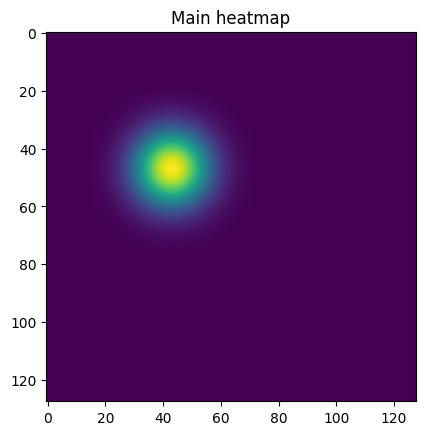

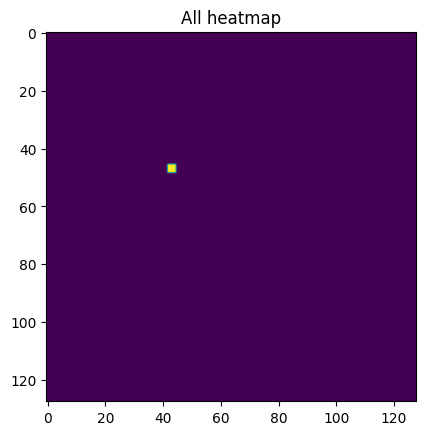

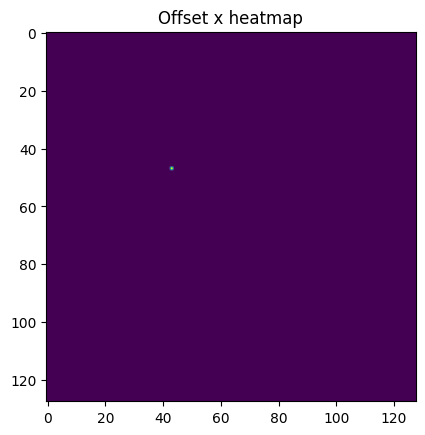

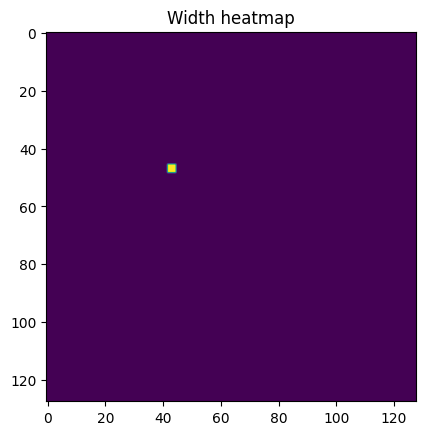

[[18.53333333 36.38518519]
 [18.53333333 36.38518519]
 [18.53333333 36.38518519]
 [18.53333333 36.38518519]
 [18.53333333 36.38518519]]
[[18.53333333 18.53333333 18.53333333 18.53333333 18.53333333]
 [36.38518519 36.38518519 36.38518519 36.38518519 36.38518519]]
[172, 184]
[168, 188]
[172, 190]
[176, 188]
[172, 192]


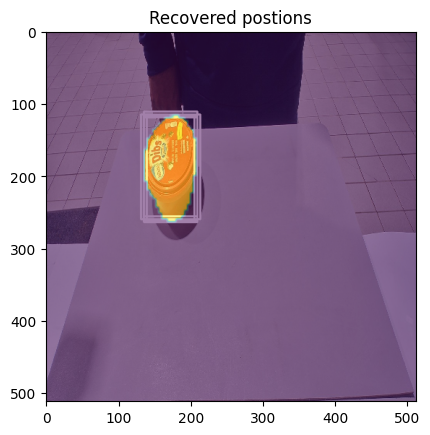

In [18]:
# Check traindataset

k = random.randint(0, len(train_id))
# Test dataset
img, hm, offset, regr,hm_all,mask = traindataset[k]

plt.imshow(hm[0])
plt.title("Main heatmap")
plt.show()

plt.imshow(hm_all)
plt.title("All heatmap")
plt.show()

plt.imshow(offset[0])
plt.title("Offset x heatmap")
plt.show()

plt.imshow(regr[0])
plt.title("Width heatmap")
plt.show()

# plt.imshow(mask)
# plt.title("Mask")
# plt.show()

# plt.imshow(corners[0])
# plt.title("Corner heatmap")
# plt.show()

#print(cos_sin_hm.shape)

# plt.imshow(cos_sin_hm[0])
# plt.title("Cos heatmap")
# plt.show()

# plt.imshow(cos_sin_hm[1])
# plt.title("Sin heatmap")
# plt.show()

# Recover ball detection from heatmaps
img = cv2.imread(train_id[k])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(input_width,input_height))
img = showbox(img, hm[0], offset, regr, 0.99)

plt.imshow(img)
plt.imshow(cv2.resize(mask,(512,512)),alpha=0.5)
plt.title("Recovered postions")
plt.show()

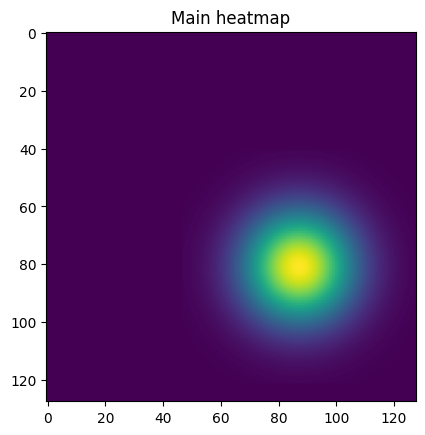

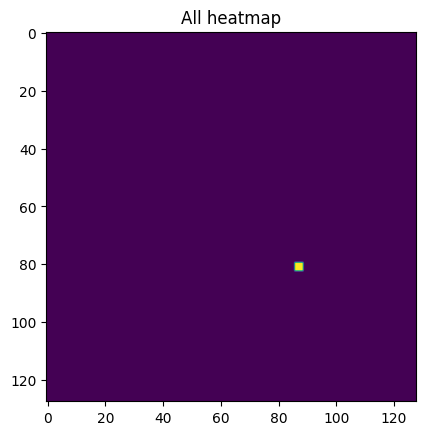

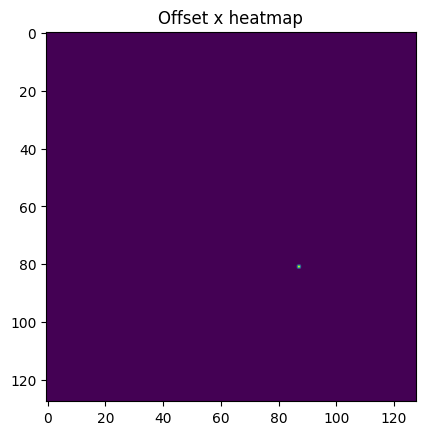

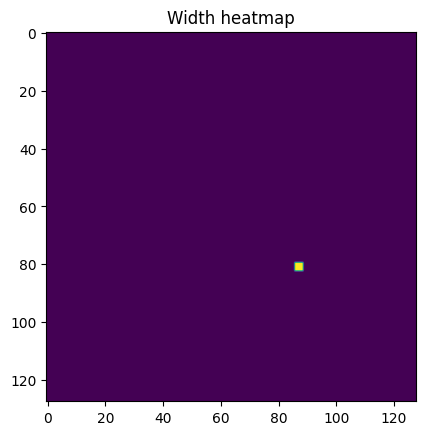

[[35.26666667 39.22962963]
 [35.26666667 39.22962963]
 [35.26666667 39.22962963]
 [35.26666667 39.22962963]
 [35.26666667 39.22962963]
 [35.26666667 39.22962963]
 [35.26666667 39.22962963]
 [35.26666667 39.22962963]
 [35.26666667 39.22962963]]
[[35.26666667 35.26666667 35.26666667 35.26666667 35.26666667 35.26666667
  35.26666667 35.26666667 35.26666667]
 [39.22962963 39.22962963 39.22962963 39.22962963 39.22962963 39.22962963
  39.22962963 39.22962963 39.22962963]]
[344, 320]
[348, 320]
[352, 320]
[344, 324]
[349, 324]
[352, 324]
[344, 328]
[348, 328]
[352, 328]


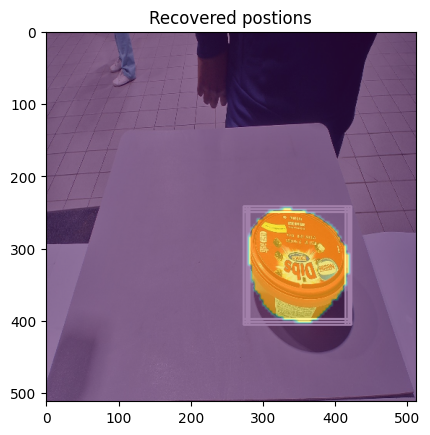

In [19]:
# Check traindataset
k = random.randint(0, len(val_id))
# Test dataset
img, hm, offset, regr,hm_all,mask= valdataset[k]

plt.imshow(hm[0])
plt.title("Main heatmap")
plt.show()

plt.imshow(hm_all)
plt.title("All heatmap")
plt.show()

plt.imshow(offset[0])
plt.title("Offset x heatmap")
plt.show()

plt.imshow(regr[0])
plt.title("Width heatmap")
plt.show()

plt.imshow(mask)
# plt.title("Mask")
# plt.show()

# plt.imshow(corners[0])
# plt.title("Corner heatmap")
# plt.show()

#print(cos_sin_hm.shape)

# plt.imshow(cos_sin_hm[0])
# plt.title("Cos heatmap")
# plt.show()

# plt.imshow(cos_sin_hm[1])
# plt.title("Sin heatmap")
# plt.show()

# Recover ball detection from heatmaps
img = cv2.imread(val_id[k])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(input_width,input_height))
img = showbox(img, hm[0], offset, regr, 0.99)

plt.imshow(img)
plt.imshow(cv2.resize(mask,(512,512)),alpha=0.5)
plt.title("Recovered postions")
plt.show()

In [20]:
train_loader = torch.utils.data.DataLoader(traindataset,batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(valdataset,batch_size=batch_size,shuffle=False)

In [21]:
timm.list_models()

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [22]:
name = 'convnext_atto'
basemodel = timm.create_model(name, features_only=True, pretrained=True)
o = basemodel(torch.rand(1,3,input_width,input_height))
fsize = []
for x in o:
    #print(x.size(2))
    if x.size(3) == input_width // 8:
        #print("Size is 160",x.shape)
        fsize.append(x.size(1))
        
    if x.size(3) == input_width // 16:
        #print("Size is 80",x.shape)
        fsize.append(x.size(1))
    
    if x.size(3) == input_width // 32:
        #print("Size is 40",x.shape)
        fsize.append(x.size(1))
fsize

[80, 160, 320]

In [23]:
for i in o:
    print(i.shape)

torch.Size([1, 40, 128, 128])
torch.Size([1, 80, 64, 64])
torch.Size([1, 160, 32, 32])
torch.Size([1, 320, 16, 16])


In [24]:
class DeformableConv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 bias=False):

        super(DeformableConv2d, self).__init__()

        self.padding = padding
        
        self.offset_conv = nn.Conv2d(in_channels, 
                                     2 * kernel_size * kernel_size,
                                     kernel_size=kernel_size, 
                                     stride=stride,
                                     padding=self.padding, 
                                     bias=True)

        nn.init.constant_(self.offset_conv.weight, 0.)
        nn.init.constant_(self.offset_conv.bias, 0.)
        
        self.modulator_conv = nn.Conv2d(in_channels, 
                                     1 * kernel_size * kernel_size,
                                     kernel_size=kernel_size, 
                                     stride=stride,
                                     padding=self.padding, 
                                     bias=True)

        nn.init.constant_(self.modulator_conv.weight, 0.)
        nn.init.constant_(self.modulator_conv.bias, 0.)
        
        self.regular_conv = nn.Conv2d(in_channels=in_channels,
                                      out_channels=out_channels,
                                      kernel_size=kernel_size,
                                      stride=stride,
                                      padding=self.padding,
                                      bias=bias)
    
    def forward(self, x):
        h, w = x.shape[2:]
        #max_offset = max(h, w)/4.

        offset = self.offset_conv(x)#.clamp(-max_offset, max_offset)
        modulator = 2. * torch.sigmoid(self.modulator_conv(x))
        
        x = torchvision.ops.deform_conv2d(input=x, 
                                          offset=offset, 
                                          weight=self.regular_conv.weight, 
                                          bias=self.regular_conv.bias, 
                                          padding=self.padding,
                                          mask=modulator
                                          )
        return x

In [25]:
def fill_up_weights(up):
    w = up.weight.data
    f = math.ceil(w.size(2) / 2)
    c = (2 * f - 1 - f % 2) / (2. * f)
    for i in range(w.size(2)):
        for j in range(w.size(3)):
            w[:, 0, i, j] = \
                (1 - math.fabs(i / f - c)) * (1 - math.fabs(j / f - c))



class Upsamling(nn.Module):
    def __init__(self, in_channels, out_channels, ksize, stride=2):
        super(Upsamling, self).__init__()
        # deconv basic config
        if ksize == 4:
            padding = 1
            output_padding = 0
        elif ksize == 3:
            padding = 1
            output_padding = 1
        elif ksize == 2:
            padding = 0
            output_padding = 0
        
        self.conv = DeformableConv2d(in_channels, out_channels)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.up = nn.ConvTranspose2d(out_channels, out_channels, ksize, stride=stride, padding=padding, output_padding=output_padding, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        fill_up_weights(self.up)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv(x)))
        x = torch.relu(self.bn2(self.up(x)))
        return x
    

## Define Centernet model

In [26]:
class centernet(nn.Module):
    def __init__(self):
        super(centernet, self).__init__()
        
        # Resnet-18 as backbone.
        #basemodel = timm.create_model('dla34', features_only=True, pretrained=True)
        #torchvision.models.resnet18(pretrained=True)
        
        # DO NOT FREEZE ResNet weights
        #for param in basemodel.parameters():
        #    param.requires_grad = False
        num_ch = 256
        head_conv = 64
        
        # Select only first layers up when you reach 80x45 dimensions with 256 channels
        self.base_model = basemodel #nn.Sequential(*list(basemodel.children())[:-3])

        self.low_level = nn.Conv2d(64, 256, kernel_size=3, padding=1)
        self.upsampler = nn.Upsample(scale_factor=2, mode='nearest') 
        self.mid_level = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.high_level = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.fpn_ = torchvision.ops.FeaturePyramidNetwork(fsize, 256)
        self.fixer = nn.Conv2d(fsize[-1], num_ch, kernel_size=3, padding=1)

        
        self.outc = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                #DeformableConv2d(num_ch, head_conv),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, len(classes), kernel_size=1, stride=1))
        
        self.outo = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                #DeformableConv2d(num_ch, head_conv),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, 2, kernel_size=1, stride=1))
        
        self.outr = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                #DeformableConv2d(num_ch, head_conv),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, 2, kernel_size=1, stride=1))

        self.outseg = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                #DeformableConv2d(num_ch, head_conv),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, 1, kernel_size=1, stride=1))
        
#         self.outa = nn.Sequential(
#                 nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
#                 #DeformableConv2d(num_ch, head_conv),
#                 nn.ReLU(inplace=True),
#                 nn.Conv2d(head_conv, 8, kernel_size=1, stride=1))

        self.upsample1 = Upsamling(256, 256, ksize=4, stride=2) # 32 -> 16
        self.upsample2 = Upsamling(256, 128, ksize=4, stride=2) # 16 -> 8
        self.upsample3 = Upsamling(128, 256, ksize=4, stride=2) #  8 -> 4
        
        self.downsm = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3,stride=2,padding=1),nn.ReLU())
        
        
    def forward(self, x):
        # [b, 3, 720, 1280]
        
        o = self.base_model(x)

        # ll_ml_hl = []
        # for x in o:
        #     #print(x.size(2))
        #     if x.size(3) == input_width // 8:
        #         #print("Size is 160",x.shape)
        #         ll_ml_hl.append(x)
                
        #     if x.size(3) == input_width // 16:
        #         #print("Size is 80",x.shape)
        #         ll_ml_hl.append(x)
        
        #     if x.size(3) == input_width // 32:
        #         #print("Size is 40",x.shape)
        #         ll_ml_hl.append(x)

        # low_level = ll_ml_hl[0]
        # mid_level = ll_ml_hl[1]
        # high_level = ll_ml_hl[2]

        # high = self.upsampler(self.high_level(high_level)) #256,80,80
        # mid = self.mid_level(mid_level) + high #256,80,80
        # low = self.upsampler(mid) + self.low_level(low_level) #256,160,160 

        # x_feats = OrderedDict()
        # x_feats['feat0'] = low_level
        # x_feats['feat2'] = mid_level
        # x_feats['feat3'] = high_level

        # x = low
        #fpn_res = self.fpn_(x_feats)
        #x = high_level
        x = o[-1] #fpn_res['feat3']
        x = self.fixer(x)
        
        x = self.upsample1(x)
        x = self.upsample2(x)
        x = self.upsample3(x)
        
        
        # [b, 128, 90, 160] 
        
        assert not torch.isnan(x).any()
        
        outc = self.outc(x) 
        # [b, 1, 90, 160]
        assert not torch.isnan(outc).any()
        
        outo = self.outo(x)
        # [b, 2, 90, 160]
        assert not torch.isnan(outo).any()
        
        outr = self.outr(x)
        #outcorner = self.outa(x)

        outseg = self.outseg(x)
        
        return outc, outo, outr,outseg #, outcorner

# Define Loss (Focal loss + L1-loss)

In [27]:
def focal_loss(pred_mask, gt,gamma=0.2):
    """
    Focal loss was introduced to address the class imbalance problem
    For example here, most of the pixels in the heatmap are negative.
    
    We split the focal loss between positive and negative losses.
    
    https://arxiv.org/pdf/1708.02002.pdf
    
    Code taken from the CenterNet repo.
    """
    gt = gt.unsqueeze(1).float()

    pos_inds = gt.ge(1.0).float()
    neg_inds = gt.lt(1.0).float()
    
    neg_weights = torch.pow(1 - gt, 4)
    
    # add 1e-12 to avoid nan values
    pos_loss = - torch.pow(1 - pred_mask, gamma) * torch.log(pred_mask + 1e-12) * pos_inds # [2, 1, 128, 128]
    neg_loss = - torch.pow(pred_mask, gamma) * torch.log(1 - pred_mask + 1e-12) * neg_inds * neg_weights # [2, 1, 128, 128]
    
    loss = 0
    
    num_pos  = pos_inds.float().sum() # scalar number of positives
    pos_loss = pos_loss.sum()
    neg_loss = neg_loss.sum()
    
    if num_pos == 0:
        loss = neg_loss
    else:
        pos_loss /= num_pos
        neg_loss /= num_pos
        loss = pos_loss + neg_loss
        
    assert not torch.isnan(pos_loss)
    assert not torch.isnan(neg_loss)
        
    return loss, pos_loss, neg_loss


def _regr_loss(off_pred, off_gt, wh_pred, wh_gt, hm_all):
    ''' L1 regression loss
    We compute l1 loss over mask of positive pixels for offset, width/height and sine/cosine angle
    '''
    #hm_gt = torch.sum(hm_gt,axis=1)

    mask = hm_all.unsqueeze(1).float().ge(1.0).float()
    
    num = mask.float().sum() 
    #mask_ = mask.expand_as(corner_gt).float()
    mask = mask.expand_as(off_gt).float()
    
    
    assert off_pred.size() == mask.size()
    off_pred = off_pred * mask
    off_gt = off_gt * mask
    wh_pred = wh_pred * mask
    wh_gt = wh_gt * mask
#     corner_pred = corner_pred * mask_
#     corner_gt = corner_gt * mask_
    # angle_pred = angle_pred * mask
    # angle_gt = angle_gt * mask
    

    off_loss = nn.functional.l1_loss(off_pred, off_gt, reduction='sum') / (num + 1e-4)
    
    # Scale with 0.1 width and height loss (change it you need)
    wh_loss = 0.1 * nn.functional.l1_loss(wh_pred, wh_gt, reduction='sum') / (num + 1e-4)
    
    #corner_loss =   0.1 * nn.functional.l1_loss(corner_pred, corner_gt, reduction='sum') / (num + 1e-4) 
    
    return off_loss, wh_loss #, corner_loss

def global_loss(hm_pred, hm_gt, off_pred, off_gt, wh_pred, wh_gt,hm_all,mask_seg,preds_mask):
    """
    Global loss is the sum of the focal loss and of the offset loss
        
    Focal loss is the sum of pos_loss and neg_loss, we extract them just for the record
    """
    
    pred_mask = torch.clamp(torch.sigmoid(hm_pred), min=1e-4, max=1-1e-4)
    #print(pred_mask.shape)
    pred_mask = pred_mask.unsqueeze(1).float()
    #print(pred_mask.shape)

    foc_loss, pos_loss, neg_loss = focal_loss(pred_mask, hm_gt)
     
    off_loss, wh_loss = _regr_loss(off_pred, off_gt, wh_pred, wh_gt, hm_all)
    
    assert not torch.isnan(off_loss)

    seg_mask = torch.clamp(torch.sigmoid(preds_mask), min=1e-4, max=1-1e-4)
    criterion_seg =  nn.BCELoss()
    loss_seg = criterion_seg(seg_mask,mask_seg.unsqueeze(1))
        
    return foc_loss, pos_loss, neg_loss, off_loss, wh_loss,loss_seg

basemodel = timm.create_model('convnext_nano', features_only=True, pretrained=True)

for i in basemodel(torch.rand(1,3,1280,720)): 
    print(i.shape)
    print(i.size(2))

# Training

In [28]:
"""
hm = torch.tensor(hm_gt)
outputs = decode_bbox(hm[None].cuda(),torch.tensor(regr_gt[None]).cuda(),torch.tensor(offset_gt[None]).cuda())
results = postprocess(outputs,True,[512, 512],image_shape, False, 0.3)
top_label   = np.array(results[0][:, 5], dtype = 'int32')
top_conf    = results[0][:, 4]
top_boxes   = results[0][:, :4]
print(top_boxes)
for box in top_boxes:
    ymin = box[0]
    xmin = box[1] 
    ymax = box[2] 
    xmax = box[3] 

    xmin = int(xmin)
    ymin = int(ymin)
    xmax = int(xmax)
    ymax = int(ymax)

    cv2.rectangle(sample,(xmin,ymin),(xmax,ymax),(255,0,255),2)



"""

"\nhm = torch.tensor(hm_gt)\noutputs = decode_bbox(hm[None].cuda(),torch.tensor(regr_gt[None]).cuda(),torch.tensor(offset_gt[None]).cuda())\nresults = postprocess(outputs,True,[512, 512],image_shape, False, 0.3)\ntop_label   = np.array(results[0][:, 5], dtype = 'int32')\ntop_conf    = results[0][:, 4]\ntop_boxes   = results[0][:, :4]\nprint(top_boxes)\nfor box in top_boxes:\n    ymin = box[0]\n    xmin = box[1] \n    ymax = box[2] \n    xmax = box[3] \n\n    xmin = int(xmin)\n    ymin = int(ymin)\n    xmax = int(xmax)\n    ymax = int(ymax)\n\n    cv2.rectangle(sample,(xmin,ymin),(xmax,ymax),(255,0,255),2)\n\n\n\n"

In [29]:
def pool_nms(heat, kernel = 3):
    pad = (kernel - 1) // 2

    hmax = nn.functional.max_pool2d(heat, (kernel, kernel), stride=1, padding=pad)
    keep = (hmax == heat).float()
    return heat * keep




def decode_bbox(pred_hms, pred_whs, pred_offsets, confidence=0.3, cuda=True):
    #-------------------------------------------------------------------------#
    #   当利用512x512x3图片进行coco数据集预测的时候
    #   h = w = 128 num_classes = 80
    #   Hot map热力图 -> b, 80, 128, 128, 
    #   进行热力图的非极大抑制，利用3x3的卷积对热力图进行最大值筛选
    #   找出一定区域内，得分最大的特征点。
    #-------------------------------------------------------------------------#
    pred_hms = pool_nms(pred_hms)
    
    b, c, output_h, output_w = pred_hms.shape
    detects = []
    #-------------------------------------------------------------------------#
    #   只传入一张图片，循环只进行一次
    #-------------------------------------------------------------------------#
    for batch in range(b):
        #-------------------------------------------------------------------------#
        #   heat_map        128*128, num_classes    热力图
        #   pred_wh         128*128, 2              特征点的预测宽高
        #                                           在预测过程的前处理以及后处理视频中讲的有点小问题，不是调整参数，就是宽高
        #   pred_offset     128*128, 2              特征点的xy轴偏移情况
        #-------------------------------------------------------------------------#
        heat_map    = pred_hms[batch].permute(1, 2, 0).view([-1, c])
        pred_wh     = pred_whs[batch].permute(1, 2, 0).view([-1, 2])
        pred_offset = pred_offsets[batch].permute(1, 2, 0).view([-1, 2])

        yv, xv      = torch.meshgrid(torch.arange(0, output_h), torch.arange(0, output_w))
        #-------------------------------------------------------------------------#
        #   xv              128*128,    特征点的x轴坐标
        #   yv              128*128,    特征点的y轴坐标
        #-------------------------------------------------------------------------#
        xv, yv      = xv.flatten().float(), yv.flatten().float()
        if cuda:
            xv      = xv.cuda()
            yv      = yv.cuda()

        #-------------------------------------------------------------------------#
        #   class_conf      128*128,    特征点的种类置信度
        #   class_pred      128*128,    特征点的种类
        #-------------------------------------------------------------------------#
        class_conf, class_pred  = torch.max(heat_map, dim = -1)
        mask                    = class_conf > confidence

        #-----------------------------------------#
        #   取出得分筛选后对应的结果
        #-----------------------------------------#
        pred_wh_mask        = pred_wh[mask]
        pred_offset_mask    = pred_offset[mask]
        if len(pred_wh_mask) == 0:
            detects.append([])
            continue     

        #----------------------------------------#
        #   计算调整后预测框的中心
        #----------------------------------------#
        xv_mask = torch.unsqueeze(xv[mask] + pred_offset_mask[..., 0], -1)
        yv_mask = torch.unsqueeze(yv[mask] + pred_offset_mask[..., 1], -1)
        #----------------------------------------#
        #   计算预测框的宽高
        #----------------------------------------#
        half_w, half_h = pred_wh_mask[..., 0:1] / 2, pred_wh_mask[..., 1:2] / 2
        #----------------------------------------#
        #   获得预测框的左上角和右下角
        #----------------------------------------#
        bboxes = torch.cat([xv_mask - half_w, yv_mask - half_h, xv_mask + half_w, yv_mask + half_h], dim=1)
        bboxes[:, [0, 2]] /= output_w
        bboxes[:, [1, 3]] /= output_h
        detect = torch.cat([bboxes, torch.unsqueeze(class_conf[mask],-1), torch.unsqueeze(class_pred[mask],-1).float()], dim=-1)
        detects.append(detect)

    return detects

def centernet_correct_boxes(box_xy, box_wh, input_shape, image_shape, letterbox_image):
    #-----------------------------------------------------------------#
    #   把y轴放前面是因为方便预测框和图像的宽高进行相乘
    #-----------------------------------------------------------------#
    box_yx = box_xy[..., ::-1]
    box_hw = box_wh[..., ::-1]
    input_shape = np.array(input_shape)
    image_shape = np.array(image_shape)

    if letterbox_image:
        #-----------------------------------------------------------------#
        #   这里求出来的offset是图像有效区域相对于图像左上角的偏移情况
        #   new_shape指的是宽高缩放情况
        #-----------------------------------------------------------------#
        new_shape = np.round(image_shape * np.min(input_shape/image_shape))
        offset  = (input_shape - new_shape)/2./input_shape
        scale   = input_shape/new_shape

        box_yx  = (box_yx - offset) * scale
        box_hw *= scale

    box_mins    = box_yx - (box_hw / 2.)
    box_maxes   = box_yx + (box_hw / 2.)
    boxes  = np.concatenate([box_mins[..., 0:1], box_mins[..., 1:2], box_maxes[..., 0:1], box_maxes[..., 1:2]], axis=-1)
    boxes *= np.concatenate([image_shape, image_shape], axis=-1)
    return boxes

def postprocess(prediction, need_nms, image_shape, input_shape, letterbox_image, nms_thres=0.4):
    output = [None for _ in range(len(prediction))]
    
    #----------------------------------------------------------#
    #   预测只用一张图片，只会进行一次
    #----------------------------------------------------------#
    for i, image_pred in enumerate(prediction):
        detections      = prediction[i]
        if len(detections) == 0:
            continue
        #------------------------------------------#
        #   获得预测结果中包含的所有种类
        #------------------------------------------#
        unique_labels   = detections[:, -1].cpu().unique()

        if detections.is_cuda:
            unique_labels = unique_labels.cuda()
            detections = detections.cuda()

        for c in unique_labels:
            #------------------------------------------#
            #   获得某一类得分筛选后全部的预测结果
            #------------------------------------------#
            detections_class = detections[detections[:, -1] == c]
            if need_nms:
                #------------------------------------------#
                #   使用官方自带的非极大抑制会速度更快一些！
                #------------------------------------------#
                keep = nms(
                    detections_class[:, :4],
                    detections_class[:, 4],
                    nms_thres
                )
                max_detections = detections_class[keep]

                # #------------------------------------------#
                # #   按照存在物体的置信度排序
                # #------------------------------------------#
                # _, conf_sort_index = torch.sort(detections_class[:, 4], descending=True)
                # detections_class = detections_class[conf_sort_index]
                # #------------------------------------------#
                # #   进行非极大抑制
                # #------------------------------------------#
                # max_detections = []
                # while detections_class.size(0):
                #     #---------------------------------------------------#
                #     #   取出这一类置信度最高的，一步一步往下判断。
                #     #   判断重合程度是否大于nms_thres，如果是则去除掉
                #     #---------------------------------------------------#
                #     max_detections.append(detections_class[0].unsqueeze(0))
                #     if len(detections_class) == 1:
                #         break
                #     ious = bbox_iou(max_detections[-1], detections_class[1:])
                #     detections_class = detections_class[1:][ious < nms_thres]
                # #------------------------------------------#
                # #   堆叠
                # #------------------------------------------#
                # max_detections = torch.cat(max_detections).data
            else:
                max_detections  = detections_class
            
            output[i] = max_detections if output[i] is None else torch.cat((output[i], max_detections))

        if output[i] is not None:
            output[i]           = output[i].cpu().numpy()
            box_xy, box_wh      = (output[i][:, 0:2] + output[i][:, 2:4])/2, output[i][:, 2:4] - output[i][:, 0:2]
            output[i][:, :4]    = centernet_correct_boxes(box_xy, box_wh, input_shape, image_shape, letterbox_image)
    return output

t = tqdm(train_loader)
device = "cuda"
for idx, (img, hm, offset, regr,hm_all) in enumerate(t):       
        # send to gpu
        img = img.to(device)
        hm_gt = hm.to(device)
        offset_gt = offset.to(device)
        wh_gt = regr.to(device)
        hm_all = hm_all.to(device)
        image_shape = [512,512]
        for t in range(len(img)):
            sample = img[t].cpu().permute(1,2,0).numpy().copy()
            hm = torch.tensor(hm_gt[t])
            #hm = torch.sigmoid(hm)
            outputs = decode_bbox(hm[None].cuda(),torch.tensor(wh_gt[t][None]).cuda(),torch.tensor(offset_gt[t][None]).cuda())
            results = postprocess(outputs,True,[512, 512],image_shape, False, 0.3)
            top_label   = np.array(results[0][:, 5], dtype = 'int32')
            top_conf    = results[0][:, 4]
            top_boxes   = results[0][:, :4]
            #print(top_boxes)
            for box in top_boxes:
                ymin = box[0]
                xmin = box[1] 
                ymax = box[2] 
                xmax = box[3] 

                xmin = int(xmin)
                ymin = int(ymin)
                xmax = int(xmax)
                ymax = int(ymax)
                #print(xmin,ymin,xmax,ymax)
                cv2.rectangle(sample,(xmin,ymin),(xmax,ymax),(255,0,255),2)
            plt.imshow(sample)
            plt.show()
            #break

In [30]:
from mean_average_precision import MetricBuilder

In [31]:
"""
# [xmin, ymin, xmax, ymax, class_id, difficult, crowd]
gt = np.array([
    [439, 157, 556, 241, 0, 0, 0],
    [437, 246, 518, 351, 0, 0, 0],
    [515, 306, 595, 375, 0, 0, 0],
    [407, 386, 531, 476, 0, 0, 0],
    [544, 419, 621, 476, 0, 0, 0],
    [609, 297, 636, 392, 0, 0, 0]
])

# [xmin, ymin, xmax, ymax, class_id, confidence]
preds = np.array([
    [429, 219, 528, 247, 0, 0.460851],
    [433, 260, 506, 336, 0, 0.269833],
    [518, 314, 603, 369, 0, 0.462608],
    [592, 310, 634, 388, 0, 0.298196],
    [403, 384, 517, 461, 0, 0.382881],
    [405, 429, 519, 470, 0, 0.369369],
    [433, 272, 499, 341, 0, 0.272826],
    [413, 390, 515, 459, 0, 0.619459]
])


"""

'\n# [xmin, ymin, xmax, ymax, class_id, difficult, crowd]\ngt = np.array([\n    [439, 157, 556, 241, 0, 0, 0],\n    [437, 246, 518, 351, 0, 0, 0],\n    [515, 306, 595, 375, 0, 0, 0],\n    [407, 386, 531, 476, 0, 0, 0],\n    [544, 419, 621, 476, 0, 0, 0],\n    [609, 297, 636, 392, 0, 0, 0]\n])\n\n# [xmin, ymin, xmax, ymax, class_id, confidence]\npreds = np.array([\n    [429, 219, 528, 247, 0, 0.460851],\n    [433, 260, 506, 336, 0, 0.269833],\n    [518, 314, 603, 369, 0, 0.462608],\n    [592, 310, 634, 388, 0, 0.298196],\n    [403, 384, 517, 461, 0, 0.382881],\n    [405, 429, 519, 470, 0, 0.369369],\n    [433, 272, 499, 341, 0, 0.272826],\n    [413, 390, 515, 459, 0, 0.619459]\n])\n\n\n'

In [32]:
classes

['cup']

In [33]:
metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=len(classes))

In [34]:
def train(epoch):
    print(f'epochs {epoch+1}/{epochs}')
    print(f'Learning rate : {optimizer.param_groups[0]["lr"]}')
    train_loss = 0.0
    train_pos_loss = 0.0
    train_neg_loss = 0.0
    train_off_loss = 0.0
    train_wh_loss = 0.0
    train_seg_loss = 0.0
    #train_corner_loss = 0.0
    #train_angle_loss = 0.0
    use_amp = True
    t = tqdm(train_loader)
    rd = np.random.rand()
    
    # Training
    model.train()
    for idx, (img, hm, offset, regr,hm_all,mask) in enumerate(t):       
        # send to gpu
        img = img.to(device)
        hm_gt = hm.to(device)
        offset_gt = offset.to(device)
        wh_gt = regr.to(device)
        hm_all = hm_all.to(device)
        mask = mask.to(device)
        #corner_gt = corner.to(device)
        #angle_gt = angle.to(device)
        # set opt
        optimizer.zero_grad()
        
        # run model
        #with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
        preds_hm, preds_offset, preds_wh, preds_mask = model(img)
        assert not np.isnan(preds_hm.cpu().detach().numpy()[0, 0, 0, 0])

        foc_loss, pos_loss, neg_loss, off_loss, wh_loss , loss_seg = global_loss(preds_hm, hm_gt, preds_offset, offset_gt, preds_wh, wh_gt,hm_all,mask,preds_mask)
        loss = foc_loss + off_loss + wh_loss + loss_seg

        if torch.isnan(loss):
            print("NAN loss")
            continue
            
        # misc
        train_loss += float(loss) # TRICK to avoid GPU memory increasing
        train_pos_loss += float(pos_loss)
        train_neg_loss += float(neg_loss)
        train_off_loss += float(off_loss)
        train_wh_loss += float(wh_loss)
        train_seg_loss += float(loss_seg)
        #train_corner_loss += float(corner_loss)
        
        loss.backward()
        # NB: I tried to use gradient clipping to avoid NaN values but it didnt work as expected
        optimizer.step()
        
        #scaler.scale(loss).backward()
        #scaler.step(optimizer)
        #scaler.update()
        #optimizer.zero_grad() # set_to_none=True here can modestly improve performance
        
        t.set_description(f'(l={train_loss/(idx+1):.2f}) (pos={train_pos_loss/(idx+1):.3f}) (neg={train_neg_loss/(idx+1):.3f}) (off={train_off_loss/(idx+1):.3f}) (wh={train_wh_loss/(idx+1):.3f})')
    
    # Validation
    val_loss = 0.0
    val_pos_loss = 0.0
    val_neg_loss = 0.0
    val_off_loss = 0.0
    val_wh_loss = 0.0
    val_seg_loss = 0.0
    #val_corner_loss = 0.0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (img, hm, offset, regr,hm_all,mask) in enumerate(tqdm(val_loader)):       
            # send to gpu
            img = img.to(device)
            hm_gt = hm.to(device)
            offset_gt = offset.to(device)
            wh_gt = regr.to(device)
            hm_all = hm_all.to(device)
            mask = mask.to(device)
            #corner_gt = corner.to(device)
            #angle_gt = angle.to(device)

            # run model
            #with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
            preds_hm, preds_offset, preds_wh,preds_mask = model(img)

            foc_loss, pos_loss, neg_loss, off_loss, wh_loss,loss_seg = global_loss(preds_hm, hm_gt, preds_offset, offset_gt, preds_wh, wh_gt,hm_all,mask,preds_mask)

            loss = foc_loss + off_loss + wh_loss + loss_seg
            
            """gt"""
            gts = []
            image_shape = [512,512]
            for t in range(len(img)):
                sample = img[t].cpu().permute(1,2,0).numpy().copy()
                hm = hm_gt[t]
                outputs = decode_bbox(hm[None].cuda(),wh_gt[t][None].cuda(),offset_gt[t][None].cuda())
                results = postprocess(outputs,True,[512, 512],image_shape, False, 0.3)
                if results is not None and len(results) > 0:
                    try:
                        top_label   = np.array(results[0][:, 5], dtype = 'int32')
                        top_conf    = results[0][:, 4]
                        top_boxes   = results[0][:, :4]

                        for (conf,label,box) in zip(top_conf,top_label,top_boxes):
                            ymin = box[0]
                            xmin = box[1] 
                            ymax = box[2] 
                            xmax = box[3] 

                            xmin = int(xmin)
                            ymin = int(ymin)
                            xmax = int(xmax)
                            ymax = int(ymax)
                            class_label = label

                            cv2.rectangle(sample,(xmin,ymin),(xmax,ymax),(255,0,255),2)
                            cv2.putText(img = sample,text = f"{classes[class_label]}",org = (xmin,ymin-5),
                            fontFace = cv2.FONT_HERSHEY_DUPLEX,fontScale = 0.8,color = (255, 255, 255),
                            thickness = 1
                            )
                            cv2.putText(img = sample,text = f"{conf:2f}",org = (xmax,ymin-5),
                            fontFace = cv2.FONT_HERSHEY_DUPLEX,fontScale = 0.8,color = (255, 255, 255),
                            thickness = 1
                            )
                            row = [xmin, ymin, xmax, ymax, label, 0, 0]
                            gts.append(row)
                    except:
                        pass
                
                    
                    
                    
                #plt.title("gt")
                #plt.imshow(sample)
                #plt.show()
                
            """pred"""
            
            preds = []
            for t in range(len(img)):
                sample = img[t].cpu().permute(1,2,0).numpy().copy()
                hm = preds_hm[t]
                hm = torch.sigmoid(hm)
                outputs = decode_bbox(hm[None].cuda(),preds_wh[t][None].cuda(),preds_offset[t][None].cuda())
                results = postprocess(outputs,True,[512, 512],image_shape, False, 0.3)
                if results is not None and len(results) > 0:
                    try:
                        top_label   = np.array(results[0][:, 5], dtype = 'int32')
                        top_conf    = results[0][:, 4]
                        top_boxes   = results[0][:, :4]

                        for (conf,label,box) in zip(top_conf,top_label,top_boxes):
                            ymin = box[0]
                            xmin = box[1] 
                            ymax = box[2] 
                            xmax = box[3] 

                            xmin = int(xmin)
                            ymin = int(ymin)
                            xmax = int(xmax)
                            ymax = int(ymax)
                            class_label = label

                            cv2.rectangle(sample,(xmin,ymin),(xmax,ymax),(255,0,255),2)
                            cv2.putText(img = sample,text = f"{classes[class_label]}",org = (xmin,ymin-5),
                            fontFace = cv2.FONT_HERSHEY_DUPLEX,fontScale = 0.8,color = (255, 255, 255),
                            thickness = 1
                            )
                            cv2.putText(img = sample,text = f"{conf:2f}",org = (xmax,ymin-5),
                            fontFace = cv2.FONT_HERSHEY_DUPLEX,fontScale = 0.8,color = (255, 255, 255),
                            thickness = 1
                            )

                            row = [xmin, ymin, xmax, ymax,label,conf]
                            preds.append(row)
                    except:
                        pass
                    
                    
#                 plt.title("pred")
#                 plt.imshow(sample)
                
#                 plt.show()
                
            preds = np.array(preds)
            gts = np.array(gts)
            metric_fn.add(preds, gts)
                
            
            
            
            
            
            
            
            
            
            
            # misc
            val_loss += float(loss)
            val_pos_loss += float(pos_loss)
            val_neg_loss += float(neg_loss)
            val_off_loss += float(off_loss)
            val_wh_loss += float(wh_loss)
            val_seg_loss += float(loss_seg)
            #val_corner_loss += float(corner_loss)
            
    mAP = metric_fn.value(iou_thresholds=0.5)['mAP']
            
    print(f"VOC PASCAL mAP in all points: {metric_fn.value(iou_thresholds=0.5)['mAP']}")

    print(f'train loss : {train_loss/len(train_loader):.4f}')
    print(f'Pos loss : {train_pos_loss/len(train_loader):.4f}')
    print(f'Neg loss : {train_neg_loss/len(train_loader):.4f}')
    print(f'Off loss : {train_off_loss/len(train_loader):.4f}')
    print(f'Wh loss : {train_wh_loss/len(train_loader):.4f}')
    print(f'Seg loss : {train_seg_loss/len(train_loader):.4f}')
    #print(f'Corner loss : {train_corner_loss/len(train_loader):.4f}')
    
    print("")
    print(f'Val loss : {val_loss/len(val_loader):.4f}')
    print(f'Val Pos loss : {val_pos_loss/len(val_loader):.4f}')
    print(f'Val Neg loss : {val_neg_loss/len(val_loader):.4f}')
    print(f'Val Off loss : {val_off_loss/len(val_loader):.4f}')
    print(f'Val Wh loss : {val_wh_loss/len(val_loader):.4f}')
    print(f'Val Seg loss : {val_seg_loss/len(val_loader):.4f}')
    #print(f'Val Corner loss : {val_corner_loss/len(val_loader):.4f}')
    
    # save logs
    log_epoch = {'epoch': epoch+1, 'lr': optimizer.state_dict()['param_groups'][0]['lr'],
                'train_loss': train_loss/len(train_loader), 'train_pos_loss': train_pos_loss/len(train_loader),
                'train_neg_loss': train_neg_loss/len(train_loader), 'train_off_loss': train_off_loss/len(train_loader), 
                'val_loss': val_loss/len(val_loader), 'val_pos_loss': val_pos_loss/len(val_loader),
                'val_neg_loss': val_neg_loss/len(val_loader), 'val_off_loss': val_off_loss/len(val_loader),
                 'mAP @0.5':mAP}
    logs.append(log_epoch)
    
    return val_loss/len(val_loader),mAP

In [36]:
#model = CenterNet_Resnet50(len(classes), pretrained = True)
model = centernet()
#model.load_state_dict(torch.load("centernet-oriented-bbox.pth"))
#model.load_state_dict(torch.load(f"centernet-xml-seg-{name}.pth"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

logs = []
best_loss = float('inf')
best_mean_AP = 0

In [37]:
img, hm, offset, regr,hm_all,msk = next(iter(train_loader))

In [38]:
hm.shape 

torch.Size([2, 1, 128, 128])

In [39]:
img.shape

torch.Size([2, 3, 512, 512])

In [40]:
epochs = 15 * 6 * 2 
use_amp = True
device = 'cuda'
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
for epoch in range(epochs):
    val_loss,mean_AP = train(epoch)
    torch.save(model.state_dict(), f"centernet-xml-seg-{name}_last.pth")  
    #scheduler.step(val_loss)
    if val_loss < best_loss:
        best_loss = val_loss
        print(f"Improved validation loss to {best_loss:.3f}")
        #torch.save(model.state_dict(), f"centernet-xml-{name}.pth")   
    if mean_AP > best_mean_AP:
        best_mean_AP = mean_AP
        print(f"Improved validation mAP to {best_mean_AP:.3f}")
        torch.save(model.state_dict(), f"centernet-xml-seg-{name}.pth")

epochs 1/180
Learning rate : 0.0001


(l=343.67) (pos=2.145) (neg=336.134) (off=0.154) (wh=5.095): 100%|█| 102/102 [00
  0%|                                                     | 0/5 [00:00<?, ?it/s]/home/rivian/anaconda3/envs/dl/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343962757/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


VOC PASCAL mAP in all points: 0.0
train loss : 343.6745
Pos loss : 2.1446
Neg loss : 336.1340
Off loss : 0.1537
Wh loss : 5.0946
Seg loss : 0.1476

Val loss : 14.9958
Val Pos loss : 1.7365
Val Neg loss : 7.9032
Val Off loss : 0.0965
Val Wh loss : 5.1365
Val Seg loss : 0.1230
Improved validation loss to 14.996
epochs 2/180
Learning rate : 0.0001


(l=11.21) (pos=1.841) (neg=5.511) (off=0.124) (wh=3.629): 100%|█| 102/102 [00:58
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


VOC PASCAL mAP in all points: 0.0
train loss : 11.2113
Pos loss : 1.8413
Neg loss : 5.5113
Off loss : 0.1235
Wh loss : 3.6285
Seg loss : 0.1067

Val loss : 8.6140
Val Pos loss : 2.0076
Val Neg loss : 3.8110
Val Off loss : 0.0997
Val Wh loss : 2.5815
Val Seg loss : 0.1142
Improved validation loss to 8.614
epochs 3/180
Learning rate : 0.0001


(l=6.49) (pos=2.032) (neg=2.943) (off=0.122) (wh=1.296): 100%|█| 102/102 [00:58<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


VOC PASCAL mAP in all points: 0.0
train loss : 6.4924
Pos loss : 2.0324
Neg loss : 2.9433
Off loss : 0.1219
Wh loss : 1.2958
Seg loss : 0.0990

Val loss : 5.5316
Val Pos loss : 1.9255
Val Neg loss : 2.1847
Val Off loss : 0.0936
Val Wh loss : 1.2281
Val Seg loss : 0.0996
Improved validation loss to 5.532
epochs 4/180
Learning rate : 0.0001


(l=4.91) (pos=1.678) (neg=1.865) (off=0.121) (wh=1.154): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


VOC PASCAL mAP in all points: 0.0
train loss : 4.9117
Pos loss : 1.6776
Neg loss : 1.8652
Off loss : 0.1207
Wh loss : 1.1536
Seg loss : 0.0947

Val loss : 4.4262
Val Pos loss : 1.5659
Val Neg loss : 1.4082
Val Off loss : 0.0970
Val Wh loss : 1.2471
Val Seg loss : 0.1080
Improved validation loss to 4.426
epochs 5/180
Learning rate : 0.0001


(l=3.98) (pos=1.444) (neg=1.296) (off=0.120) (wh=1.030): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


VOC PASCAL mAP in all points: 0.0
train loss : 3.9807
Pos loss : 1.4444
Neg loss : 1.2957
Off loss : 0.1198
Wh loss : 1.0301
Seg loss : 0.0908

Val loss : 3.7090
Val Pos loss : 1.3159
Val Neg loss : 1.0178
Val Off loss : 0.1004
Val Wh loss : 1.1748
Val Seg loss : 0.1000
Improved validation loss to 3.709
epochs 6/180
Learning rate : 0.0001


(l=3.40) (pos=1.269) (neg=0.985) (off=0.119) (wh=0.939): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


VOC PASCAL mAP in all points: 0.0833333358168602
train loss : 3.3971
Pos loss : 1.2688
Neg loss : 0.9846
Off loss : 0.1192
Wh loss : 0.9392
Seg loss : 0.0853

Val loss : 3.0408
Val Pos loss : 1.1922
Val Neg loss : 0.8037
Val Off loss : 0.0937
Val Wh loss : 0.8650
Val Seg loss : 0.0862
Improved validation loss to 3.041
Improved validation mAP to 0.083
epochs 7/180
Learning rate : 0.0001


(l=3.08) (pos=1.101) (neg=0.817) (off=0.121) (wh=0.974): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


VOC PASCAL mAP in all points: 0.14770562946796417
train loss : 3.0823
Pos loss : 1.1010
Neg loss : 0.8168
Off loss : 0.1209
Wh loss : 0.9744
Seg loss : 0.0693

Val loss : 2.9276
Val Pos loss : 1.0925
Val Neg loss : 0.8311
Val Off loss : 0.0947
Val Wh loss : 0.8449
Val Seg loss : 0.0644
Improved validation loss to 2.928
Improved validation mAP to 0.148
epochs 8/180
Learning rate : 0.0001


(l=2.76) (pos=0.933) (neg=0.670) (off=0.121) (wh=0.975): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]


VOC PASCAL mAP in all points: 0.24623213708400726
train loss : 2.7616
Pos loss : 0.9328
Neg loss : 0.6696
Off loss : 0.1209
Wh loss : 0.9753
Seg loss : 0.0629

Val loss : 2.4446
Val Pos loss : 0.8706
Val Neg loss : 0.5492
Val Off loss : 0.0956
Val Wh loss : 0.8644
Val Seg loss : 0.0648
Improved validation loss to 2.445
Improved validation mAP to 0.246
epochs 9/180
Learning rate : 0.0001


(l=2.42) (pos=0.826) (neg=0.524) (off=0.123) (wh=0.905): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


VOC PASCAL mAP in all points: 0.3111816644668579
train loss : 2.4248
Pos loss : 0.8259
Neg loss : 0.5240
Off loss : 0.1230
Wh loss : 0.9049
Seg loss : 0.0470

Val loss : 2.1845
Val Pos loss : 0.7866
Val Neg loss : 0.4001
Val Off loss : 0.0987
Val Wh loss : 0.8397
Val Seg loss : 0.0593
Improved validation loss to 2.184
Improved validation mAP to 0.311
epochs 10/180
Learning rate : 0.0001


(l=3.71) (pos=1.117) (neg=1.133) (off=0.126) (wh=1.293): 100%|█| 102/102 [01:00<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


VOC PASCAL mAP in all points: 0.2800634801387787
train loss : 3.7127
Pos loss : 1.1173
Neg loss : 1.1326
Off loss : 0.1265
Wh loss : 1.2932
Seg loss : 0.0431

Val loss : 5.2119
Val Pos loss : 2.0121
Val Neg loss : 1.7941
Val Off loss : 0.1038
Val Wh loss : 1.2314
Val Seg loss : 0.0706
epochs 11/180
Learning rate : 0.0001


(l=3.39) (pos=1.276) (neg=0.651) (off=0.123) (wh=1.276): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.62it/s]


VOC PASCAL mAP in all points: 0.3291133940219879
train loss : 3.3876
Pos loss : 1.2759
Neg loss : 0.6505
Off loss : 0.1226
Wh loss : 1.2756
Seg loss : 0.0629

Val loss : 2.4592
Val Pos loss : 0.8632
Val Neg loss : 0.3781
Val Off loss : 0.0924
Val Wh loss : 1.0684
Val Seg loss : 0.0571
Improved validation mAP to 0.329
epochs 12/180
Learning rate : 0.0001


(l=2.48) (pos=0.825) (neg=0.398) (off=0.120) (wh=1.098): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


VOC PASCAL mAP in all points: 0.3690612018108368
train loss : 2.4834
Pos loss : 0.8247
Neg loss : 0.3980
Off loss : 0.1200
Wh loss : 1.0976
Seg loss : 0.0431

Val loss : 2.3068
Val Pos loss : 0.7433
Val Neg loss : 0.2968
Val Off loss : 0.0984
Val Wh loss : 1.1113
Val Seg loss : 0.0570
Improved validation mAP to 0.369
epochs 13/180
Learning rate : 0.0001


(l=3.40) (pos=1.289) (neg=0.680) (off=0.126) (wh=1.258): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


VOC PASCAL mAP in all points: 0.33914029598236084
train loss : 3.3979
Pos loss : 1.2891
Neg loss : 0.6796
Off loss : 0.1262
Wh loss : 1.2583
Seg loss : 0.0446

Val loss : 4.8075
Val Pos loss : 2.7976
Val Neg loss : 0.3685
Val Off loss : 0.1190
Val Wh loss : 1.3758
Val Seg loss : 0.1466
epochs 14/180
Learning rate : 0.0001


(l=2.52) (pos=0.794) (neg=0.441) (off=0.122) (wh=1.113): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


VOC PASCAL mAP in all points: 0.3607766032218933
train loss : 2.5233
Pos loss : 0.7936
Neg loss : 0.4413
Off loss : 0.1220
Wh loss : 1.1129
Seg loss : 0.0536

Val loss : 1.9667
Val Pos loss : 0.6076
Val Neg loss : 0.2877
Val Off loss : 0.0938
Val Wh loss : 0.9300
Val Seg loss : 0.0477
Improved validation loss to 1.967
epochs 15/180
Learning rate : 0.0001


(l=2.57) (pos=0.764) (neg=0.606) (off=0.122) (wh=1.019): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


VOC PASCAL mAP in all points: 0.3822740912437439
train loss : 2.5680
Pos loss : 0.7638
Neg loss : 0.6059
Off loss : 0.1220
Wh loss : 1.0194
Seg loss : 0.0569

Val loss : 3.5176
Val Pos loss : 1.0069
Val Neg loss : 1.0843
Val Off loss : 0.1014
Val Wh loss : 1.1720
Val Seg loss : 0.1530
Improved validation mAP to 0.382
epochs 16/180
Learning rate : 0.0001


(l=3.40) (pos=1.245) (neg=0.634) (off=0.125) (wh=1.315): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


VOC PASCAL mAP in all points: 0.41077959537506104
train loss : 3.4001
Pos loss : 1.2455
Neg loss : 0.6335
Off loss : 0.1254
Wh loss : 1.3154
Seg loss : 0.0803

Val loss : 2.0749
Val Pos loss : 0.5119
Val Neg loss : 0.2823
Val Off loss : 0.0922
Val Wh loss : 1.1281
Val Seg loss : 0.0604
Improved validation mAP to 0.411
epochs 17/180
Learning rate : 0.0001


(l=2.07) (pos=0.543) (neg=0.339) (off=0.121) (wh=1.017): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


VOC PASCAL mAP in all points: 0.4521138072013855
train loss : 2.0699
Pos loss : 0.5427
Neg loss : 0.3392
Off loss : 0.1209
Wh loss : 1.0168
Seg loss : 0.0503

Val loss : 1.8588
Val Pos loss : 0.4486
Val Neg loss : 0.2785
Val Off loss : 0.0958
Val Wh loss : 0.9873
Val Seg loss : 0.0485
Improved validation loss to 1.859
Improved validation mAP to 0.452
epochs 18/180
Learning rate : 0.0001


(l=1.86) (pos=0.459) (neg=0.300) (off=0.121) (wh=0.935): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


VOC PASCAL mAP in all points: 0.47245362401008606
train loss : 1.8575
Pos loss : 0.4588
Neg loss : 0.3004
Off loss : 0.1208
Wh loss : 0.9350
Seg loss : 0.0425

Val loss : 1.8898
Val Pos loss : 0.4118
Val Neg loss : 0.2653
Val Off loss : 0.0956
Val Wh loss : 1.0688
Val Seg loss : 0.0483
Improved validation mAP to 0.472
epochs 19/180
Learning rate : 0.0001


(l=1.77) (pos=0.376) (neg=0.290) (off=0.125) (wh=0.938): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


VOC PASCAL mAP in all points: 0.4902263581752777
train loss : 1.7675
Pos loss : 0.3759
Neg loss : 0.2901
Off loss : 0.1254
Wh loss : 0.9379
Seg loss : 0.0382

Val loss : 1.7364
Val Pos loss : 0.3309
Val Neg loss : 0.2695
Val Off loss : 0.1029
Val Wh loss : 0.9803
Val Seg loss : 0.0529
Improved validation loss to 1.736
Improved validation mAP to 0.490
epochs 20/180
Learning rate : 0.0001


(l=1.68) (pos=0.312) (neg=0.268) (off=0.122) (wh=0.939): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]


VOC PASCAL mAP in all points: 0.5060862302780151
train loss : 1.6774
Pos loss : 0.3119
Neg loss : 0.2680
Off loss : 0.1224
Wh loss : 0.9393
Seg loss : 0.0358

Val loss : 1.5461
Val Pos loss : 0.2508
Val Neg loss : 0.2462
Val Off loss : 0.0951
Val Wh loss : 0.9011
Val Seg loss : 0.0529
Improved validation loss to 1.546
Improved validation mAP to 0.506
epochs 21/180
Learning rate : 0.0001


(l=1.58) (pos=0.255) (neg=0.264) (off=0.121) (wh=0.903): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.81it/s]


VOC PASCAL mAP in all points: 0.5069991946220398
train loss : 1.5757
Pos loss : 0.2550
Neg loss : 0.2645
Off loss : 0.1207
Wh loss : 0.9034
Seg loss : 0.0321

Val loss : 1.4513
Val Pos loss : 0.2538
Val Neg loss : 0.2418
Val Off loss : 0.0943
Val Wh loss : 0.8276
Val Seg loss : 0.0338
Improved validation loss to 1.451
Improved validation mAP to 0.507
epochs 22/180
Learning rate : 0.0001


(l=1.52) (pos=0.213) (neg=0.261) (off=0.120) (wh=0.900): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


VOC PASCAL mAP in all points: 0.5238497257232666
train loss : 1.5231
Pos loss : 0.2131
Neg loss : 0.2609
Off loss : 0.1201
Wh loss : 0.8996
Seg loss : 0.0294

Val loss : 1.5393
Val Pos loss : 0.1877
Val Neg loss : 0.2418
Val Off loss : 0.0954
Val Wh loss : 0.9812
Val Seg loss : 0.0332
Improved validation mAP to 0.524
epochs 23/180
Learning rate : 0.0001


(l=1.44) (pos=0.171) (neg=0.259) (off=0.121) (wh=0.864): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


VOC PASCAL mAP in all points: 0.5380149483680725
train loss : 1.4441
Pos loss : 0.1714
Neg loss : 0.2587
Off loss : 0.1215
Wh loss : 0.8637
Seg loss : 0.0288

Val loss : 1.3586
Val Pos loss : 0.1321
Val Neg loss : 0.2470
Val Off loss : 0.0928
Val Wh loss : 0.8522
Val Seg loss : 0.0346
Improved validation loss to 1.359
Improved validation mAP to 0.538
epochs 24/180
Learning rate : 0.0001


(l=1.45) (pos=0.142) (neg=0.263) (off=0.120) (wh=0.896): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


VOC PASCAL mAP in all points: 0.5374273061752319
train loss : 1.4521
Pos loss : 0.1423
Neg loss : 0.2633
Off loss : 0.1200
Wh loss : 0.8963
Seg loss : 0.0302

Val loss : 1.2920
Val Pos loss : 0.1451
Val Neg loss : 0.2453
Val Off loss : 0.0922
Val Wh loss : 0.7811
Val Seg loss : 0.0283
Improved validation loss to 1.292
epochs 25/180
Learning rate : 0.0001


(l=1.36) (pos=0.114) (neg=0.262) (off=0.120) (wh=0.843): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


VOC PASCAL mAP in all points: 0.5505945086479187
train loss : 1.3643
Pos loss : 0.1142
Neg loss : 0.2620
Off loss : 0.1203
Wh loss : 0.8426
Seg loss : 0.0254

Val loss : 1.3516
Val Pos loss : 0.1062
Val Neg loss : 0.2803
Val Off loss : 0.0930
Val Wh loss : 0.8401
Val Seg loss : 0.0320
Improved validation mAP to 0.551
epochs 26/180
Learning rate : 0.0001


(l=1.32) (pos=0.102) (neg=0.260) (off=0.119) (wh=0.811): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


VOC PASCAL mAP in all points: 0.5631639957427979
train loss : 1.3196
Pos loss : 0.1020
Neg loss : 0.2605
Off loss : 0.1192
Wh loss : 0.8114
Seg loss : 0.0265

Val loss : 1.3896
Val Pos loss : 0.0921
Val Neg loss : 0.2582
Val Off loss : 0.0937
Val Wh loss : 0.9222
Val Seg loss : 0.0234
Improved validation mAP to 0.563
epochs 27/180
Learning rate : 0.0001


(l=1.26) (pos=0.084) (neg=0.258) (off=0.120) (wh=0.773): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


VOC PASCAL mAP in all points: 0.5848931670188904
train loss : 1.2588
Pos loss : 0.0841
Neg loss : 0.2583
Off loss : 0.1199
Wh loss : 0.7729
Seg loss : 0.0237

Val loss : 1.2750
Val Pos loss : 0.0620
Val Neg loss : 0.2432
Val Off loss : 0.0921
Val Wh loss : 0.8559
Val Seg loss : 0.0218
Improved validation loss to 1.275
Improved validation mAP to 0.585
epochs 28/180
Learning rate : 0.0001


(l=1.27) (pos=0.102) (neg=0.292) (off=0.120) (wh=0.730): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.81it/s]


VOC PASCAL mAP in all points: 0.6038284301757812
train loss : 1.2672
Pos loss : 0.1021
Neg loss : 0.2916
Off loss : 0.1199
Wh loss : 0.7297
Seg loss : 0.0240

Val loss : 1.0983
Val Pos loss : 0.0506
Val Neg loss : 0.2415
Val Off loss : 0.0930
Val Wh loss : 0.6859
Val Seg loss : 0.0274
Improved validation loss to 1.098
Improved validation mAP to 0.604
epochs 29/180
Learning rate : 0.0001


(l=1.20) (pos=0.091) (neg=0.278) (off=0.121) (wh=0.682): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


VOC PASCAL mAP in all points: 0.6098005175590515
train loss : 1.1953
Pos loss : 0.0908
Neg loss : 0.2776
Off loss : 0.1207
Wh loss : 0.6823
Seg loss : 0.0238

Val loss : 1.1316
Val Pos loss : 0.0390
Val Neg loss : 0.2715
Val Off loss : 0.0951
Val Wh loss : 0.7067
Val Seg loss : 0.0193
Improved validation mAP to 0.610
epochs 30/180
Learning rate : 0.0001


(l=1.16) (pos=0.077) (neg=0.299) (off=0.120) (wh=0.641): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


VOC PASCAL mAP in all points: 0.6258401870727539
train loss : 1.1618
Pos loss : 0.0772
Neg loss : 0.2993
Off loss : 0.1203
Wh loss : 0.6411
Seg loss : 0.0239

Val loss : 1.0856
Val Pos loss : 0.0453
Val Neg loss : 0.2551
Val Off loss : 0.0927
Val Wh loss : 0.6705
Val Seg loss : 0.0221
Improved validation loss to 1.086
Improved validation mAP to 0.626
epochs 31/180
Learning rate : 0.0001


(l=1.05) (pos=0.076) (neg=0.277) (off=0.120) (wh=0.557): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


VOC PASCAL mAP in all points: 0.6308266520500183
train loss : 1.0531
Pos loss : 0.0762
Neg loss : 0.2766
Off loss : 0.1198
Wh loss : 0.5568
Seg loss : 0.0236

Val loss : 1.0294
Val Pos loss : 0.0366
Val Neg loss : 0.2776
Val Off loss : 0.0930
Val Wh loss : 0.5998
Val Seg loss : 0.0224
Improved validation loss to 1.029
Improved validation mAP to 0.631
epochs 32/180
Learning rate : 0.0001


(l=1.04) (pos=0.060) (neg=0.277) (off=0.120) (wh=0.555): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


VOC PASCAL mAP in all points: 0.644682765007019
train loss : 1.0355
Pos loss : 0.0600
Neg loss : 0.2766
Off loss : 0.1202
Wh loss : 0.5554
Seg loss : 0.0233

Val loss : 0.8728
Val Pos loss : 0.0219
Val Neg loss : 0.2485
Val Off loss : 0.0928
Val Wh loss : 0.4907
Val Seg loss : 0.0189
Improved validation loss to 0.873
Improved validation mAP to 0.645
epochs 33/180
Learning rate : 0.0001


(l=0.86) (pos=0.033) (neg=0.263) (off=0.119) (wh=0.428): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


VOC PASCAL mAP in all points: 0.657616376876831
train loss : 0.8628
Pos loss : 0.0332
Neg loss : 0.2627
Off loss : 0.1194
Wh loss : 0.4280
Seg loss : 0.0195

Val loss : 0.9735
Val Pos loss : 0.0282
Val Neg loss : 0.3070
Val Off loss : 0.0953
Val Wh loss : 0.5201
Val Seg loss : 0.0230
Improved validation mAP to 0.658
epochs 34/180
Learning rate : 0.0001


(l=0.80) (pos=0.038) (neg=0.263) (off=0.119) (wh=0.365): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


VOC PASCAL mAP in all points: 0.669551432132721
train loss : 0.8047
Pos loss : 0.0381
Neg loss : 0.2629
Off loss : 0.1193
Wh loss : 0.3655
Seg loss : 0.0190

Val loss : 0.7853
Val Pos loss : 0.0153
Val Neg loss : 0.2709
Val Off loss : 0.0968
Val Wh loss : 0.3845
Val Seg loss : 0.0179
Improved validation loss to 0.785
Improved validation mAP to 0.670
epochs 35/180
Learning rate : 0.0001


(l=0.79) (pos=0.026) (neg=0.259) (off=0.121) (wh=0.364): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


VOC PASCAL mAP in all points: 0.6807068586349487
train loss : 0.7887
Pos loss : 0.0261
Neg loss : 0.2586
Off loss : 0.1206
Wh loss : 0.3644
Seg loss : 0.0191

Val loss : 0.7469
Val Pos loss : 0.0116
Val Neg loss : 0.2662
Val Off loss : 0.0931
Val Wh loss : 0.3605
Val Seg loss : 0.0155
Improved validation loss to 0.747
Improved validation mAP to 0.681
epochs 36/180
Learning rate : 0.0001


(l=0.79) (pos=0.029) (neg=0.256) (off=0.120) (wh=0.372): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


VOC PASCAL mAP in all points: 0.6909629106521606
train loss : 0.7946
Pos loss : 0.0286
Neg loss : 0.2561
Off loss : 0.1199
Wh loss : 0.3719
Seg loss : 0.0181

Val loss : 1.0059
Val Pos loss : 0.0249
Val Neg loss : 0.3338
Val Off loss : 0.0940
Val Wh loss : 0.5337
Val Seg loss : 0.0194
Improved validation mAP to 0.691
epochs 37/180
Learning rate : 0.0001


(l=0.82) (pos=0.025) (neg=0.262) (off=0.120) (wh=0.398): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


VOC PASCAL mAP in all points: 0.7006636261940002
train loss : 0.8241
Pos loss : 0.0252
Neg loss : 0.2617
Off loss : 0.1198
Wh loss : 0.3979
Seg loss : 0.0195

Val loss : 0.7252
Val Pos loss : 0.0091
Val Neg loss : 0.2480
Val Off loss : 0.0929
Val Wh loss : 0.3577
Val Seg loss : 0.0175
Improved validation loss to 0.725
Improved validation mAP to 0.701
epochs 38/180
Learning rate : 0.0001


(l=0.77) (pos=0.020) (neg=0.257) (off=0.121) (wh=0.359): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


VOC PASCAL mAP in all points: 0.7096863985061646
train loss : 0.7741
Pos loss : 0.0205
Neg loss : 0.2567
Off loss : 0.1206
Wh loss : 0.3586
Seg loss : 0.0177

Val loss : 0.6726
Val Pos loss : 0.0114
Val Neg loss : 0.2443
Val Off loss : 0.0923
Val Wh loss : 0.3048
Val Seg loss : 0.0199
Improved validation loss to 0.673
Improved validation mAP to 0.710
epochs 39/180
Learning rate : 0.0001


(l=0.70) (pos=0.018) (neg=0.253) (off=0.119) (wh=0.298): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


VOC PASCAL mAP in all points: 0.7182019352912903
train loss : 0.7042
Pos loss : 0.0185
Neg loss : 0.2526
Off loss : 0.1193
Wh loss : 0.2981
Seg loss : 0.0157

Val loss : 0.7072
Val Pos loss : 0.0080
Val Neg loss : 0.2517
Val Off loss : 0.0922
Val Wh loss : 0.3412
Val Seg loss : 0.0141
Improved validation mAP to 0.718
epochs 40/180
Learning rate : 0.0001


(l=0.69) (pos=0.015) (neg=0.252) (off=0.119) (wh=0.288): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


VOC PASCAL mAP in all points: 0.7263431549072266
train loss : 0.6888
Pos loss : 0.0145
Neg loss : 0.2518
Off loss : 0.1193
Wh loss : 0.2876
Seg loss : 0.0155

Val loss : 0.6507
Val Pos loss : 0.0064
Val Neg loss : 0.2489
Val Off loss : 0.0928
Val Wh loss : 0.2873
Val Seg loss : 0.0153
Improved validation loss to 0.651
Improved validation mAP to 0.726
epochs 41/180
Learning rate : 0.0001


(l=0.66) (pos=0.014) (neg=0.253) (off=0.117) (wh=0.258): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


VOC PASCAL mAP in all points: 0.7339025139808655
train loss : 0.6608
Pos loss : 0.0140
Neg loss : 0.2534
Off loss : 0.1173
Wh loss : 0.2582
Seg loss : 0.0178

Val loss : 0.8681
Val Pos loss : 0.0080
Val Neg loss : 0.2455
Val Off loss : 0.0914
Val Wh loss : 0.5016
Val Seg loss : 0.0217
Improved validation mAP to 0.734
epochs 42/180
Learning rate : 0.0001


(l=0.69) (pos=0.017) (neg=0.254) (off=0.119) (wh=0.281): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


VOC PASCAL mAP in all points: 0.7411003112792969
train loss : 0.6877
Pos loss : 0.0172
Neg loss : 0.2539
Off loss : 0.1192
Wh loss : 0.2807
Seg loss : 0.0167

Val loss : 0.5889
Val Pos loss : 0.0061
Val Neg loss : 0.2399
Val Off loss : 0.0922
Val Wh loss : 0.2379
Val Seg loss : 0.0128
Improved validation loss to 0.589
Improved validation mAP to 0.741
epochs 43/180
Learning rate : 0.0001


(l=0.66) (pos=0.013) (neg=0.249) (off=0.119) (wh=0.268): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.73it/s]


VOC PASCAL mAP in all points: 0.747869074344635
train loss : 0.6641
Pos loss : 0.0127
Neg loss : 0.2493
Off loss : 0.1188
Wh loss : 0.2678
Seg loss : 0.0153

Val loss : 0.6839
Val Pos loss : 0.0083
Val Neg loss : 0.2459
Val Off loss : 0.0933
Val Wh loss : 0.3189
Val Seg loss : 0.0174
Improved validation mAP to 0.748
epochs 44/180
Learning rate : 0.0001


(l=0.66) (pos=0.011) (neg=0.250) (off=0.118) (wh=0.271): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


VOC PASCAL mAP in all points: 0.7542904615402222
train loss : 0.6640
Pos loss : 0.0109
Neg loss : 0.2496
Off loss : 0.1183
Wh loss : 0.2706
Seg loss : 0.0145

Val loss : 0.6872
Val Pos loss : 0.0063
Val Neg loss : 0.2462
Val Off loss : 0.0921
Val Wh loss : 0.3301
Val Seg loss : 0.0125
Improved validation mAP to 0.754
epochs 45/180
Learning rate : 0.0001


(l=0.68) (pos=0.015) (neg=0.260) (off=0.118) (wh=0.275): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.74it/s]


VOC PASCAL mAP in all points: 0.7533771991729736
train loss : 0.6847
Pos loss : 0.0151
Neg loss : 0.2604
Off loss : 0.1185
Wh loss : 0.2746
Seg loss : 0.0161

Val loss : 0.8835
Val Pos loss : 0.0110
Val Neg loss : 0.2574
Val Off loss : 0.0932
Val Wh loss : 0.5005
Val Seg loss : 0.0213
epochs 46/180
Learning rate : 0.0001


(l=0.75) (pos=0.018) (neg=0.263) (off=0.118) (wh=0.332): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


VOC PASCAL mAP in all points: 0.7593016028404236
train loss : 0.7481
Pos loss : 0.0185
Neg loss : 0.2633
Off loss : 0.1182
Wh loss : 0.3320
Seg loss : 0.0161

Val loss : 0.6811
Val Pos loss : 0.0079
Val Neg loss : 0.2447
Val Off loss : 0.0932
Val Wh loss : 0.3202
Val Seg loss : 0.0151
Improved validation mAP to 0.759
epochs 47/180
Learning rate : 0.0001


(l=0.68) (pos=0.011) (neg=0.250) (off=0.119) (wh=0.282): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.84it/s]


VOC PASCAL mAP in all points: 0.7651528120040894
train loss : 0.6779
Pos loss : 0.0107
Neg loss : 0.2499
Off loss : 0.1185
Wh loss : 0.2820
Seg loss : 0.0168

Val loss : 0.7217
Val Pos loss : 0.0039
Val Neg loss : 0.2471
Val Off loss : 0.0916
Val Wh loss : 0.3646
Val Seg loss : 0.0145
Improved validation mAP to 0.765
epochs 48/180
Learning rate : 0.0001


(l=0.66) (pos=0.009) (neg=0.250) (off=0.118) (wh=0.271): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


VOC PASCAL mAP in all points: 0.7706515192985535
train loss : 0.6632
Pos loss : 0.0088
Neg loss : 0.2504
Off loss : 0.1177
Wh loss : 0.2714
Seg loss : 0.0149

Val loss : 0.6705
Val Pos loss : 0.0064
Val Neg loss : 0.2505
Val Off loss : 0.0912
Val Wh loss : 0.3111
Val Seg loss : 0.0113
Improved validation mAP to 0.771
epochs 49/180
Learning rate : 0.0001


(l=0.65) (pos=0.010) (neg=0.250) (off=0.118) (wh=0.260): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


VOC PASCAL mAP in all points: 0.7759020924568176
train loss : 0.6510
Pos loss : 0.0099
Neg loss : 0.2497
Off loss : 0.1178
Wh loss : 0.2600
Seg loss : 0.0136

Val loss : 0.5604
Val Pos loss : 0.0051
Val Neg loss : 0.2471
Val Off loss : 0.0919
Val Wh loss : 0.2030
Val Seg loss : 0.0132
Improved validation loss to 0.560
Improved validation mAP to 0.776
epochs 50/180
Learning rate : 0.0001


(l=0.65) (pos=0.008) (neg=0.249) (off=0.119) (wh=0.259): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


VOC PASCAL mAP in all points: 0.7809032797813416
train loss : 0.6480
Pos loss : 0.0076
Neg loss : 0.2493
Off loss : 0.1187
Wh loss : 0.2587
Seg loss : 0.0137

Val loss : 0.5434
Val Pos loss : 0.0063
Val Neg loss : 0.2502
Val Off loss : 0.0924
Val Wh loss : 0.1819
Val Seg loss : 0.0125
Improved validation loss to 0.543
Improved validation mAP to 0.781
epochs 51/180
Learning rate : 0.0001


(l=0.64) (pos=0.007) (neg=0.248) (off=0.118) (wh=0.253): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


VOC PASCAL mAP in all points: 0.7856740355491638
train loss : 0.6397
Pos loss : 0.0074
Neg loss : 0.2475
Off loss : 0.1181
Wh loss : 0.2534
Seg loss : 0.0134

Val loss : 0.5313
Val Pos loss : 0.0033
Val Neg loss : 0.2386
Val Off loss : 0.0911
Val Wh loss : 0.1863
Val Seg loss : 0.0121
Improved validation loss to 0.531
Improved validation mAP to 0.786
epochs 52/180
Learning rate : 0.0001


(l=0.63) (pos=0.009) (neg=0.251) (off=0.119) (wh=0.233): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]


VOC PASCAL mAP in all points: 0.7845162153244019
train loss : 0.6252
Pos loss : 0.0093
Neg loss : 0.2507
Off loss : 0.1189
Wh loss : 0.2327
Seg loss : 0.0137

Val loss : 0.8325
Val Pos loss : 0.0071
Val Neg loss : 0.2446
Val Off loss : 0.0914
Val Wh loss : 0.4746
Val Seg loss : 0.0147
epochs 53/180
Learning rate : 0.0001


(l=0.69) (pos=0.008) (neg=0.251) (off=0.119) (wh=0.297): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


VOC PASCAL mAP in all points: 0.7889448404312134
train loss : 0.6894
Pos loss : 0.0081
Neg loss : 0.2508
Off loss : 0.1188
Wh loss : 0.2969
Seg loss : 0.0149

Val loss : 0.6893
Val Pos loss : 0.0031
Val Neg loss : 0.2434
Val Off loss : 0.0916
Val Wh loss : 0.3391
Val Seg loss : 0.0121
Improved validation mAP to 0.789
epochs 54/180
Learning rate : 0.0001


(l=0.65) (pos=0.006) (neg=0.250) (off=0.118) (wh=0.263): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


VOC PASCAL mAP in all points: 0.7932847738265991
train loss : 0.6504
Pos loss : 0.0060
Neg loss : 0.2499
Off loss : 0.1179
Wh loss : 0.2629
Seg loss : 0.0138

Val loss : 0.6033
Val Pos loss : 0.0028
Val Neg loss : 0.2393
Val Off loss : 0.0930
Val Wh loss : 0.2541
Val Seg loss : 0.0140
Improved validation mAP to 0.793
epochs 55/180
Learning rate : 0.0001


(l=1.98) (pos=0.822) (neg=0.493) (off=0.120) (wh=0.513): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


VOC PASCAL mAP in all points: 0.7751802206039429
train loss : 1.9793
Pos loss : 0.8224
Neg loss : 0.4932
Off loss : 0.1195
Wh loss : 0.5130
Seg loss : 0.0311

Val loss : 10.5870
Val Pos loss : 7.7721
Val Neg loss : 0.7597
Val Off loss : 0.1063
Val Wh loss : 1.8315
Val Seg loss : 0.1174
epochs 56/180
Learning rate : 0.0001


(l=10.24) (pos=7.929) (neg=0.900) (off=0.123) (wh=1.137): 100%|█| 102/102 [00:58
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]


VOC PASCAL mAP in all points: 0.7613377571105957
train loss : 10.2433
Pos loss : 7.9292
Neg loss : 0.9003
Off loss : 0.1227
Wh loss : 1.1375
Seg loss : 0.1537

Val loss : 10.0442
Val Pos loss : 7.8241
Val Neg loss : 0.8670
Val Off loss : 0.0989
Val Wh loss : 1.0958
Val Seg loss : 0.1584
epochs 57/180
Learning rate : 0.0001


(l=9.78) (pos=7.562) (neg=0.948) (off=0.121) (wh=1.007): 100%|█| 102/102 [00:58<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


VOC PASCAL mAP in all points: 0.7479809522628784
train loss : 9.7838
Pos loss : 7.5625
Neg loss : 0.9476
Off loss : 0.1207
Wh loss : 1.0073
Seg loss : 0.1457

Val loss : 9.7335
Val Pos loss : 7.2237
Val Neg loss : 1.2797
Val Off loss : 0.0927
Val Wh loss : 0.9813
Val Seg loss : 0.1561
epochs 58/180
Learning rate : 0.0001


(l=9.61) (pos=7.423) (neg=0.960) (off=0.118) (wh=0.965): 100%|█| 102/102 [00:58<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


VOC PASCAL mAP in all points: 0.7350847125053406
train loss : 9.6098
Pos loss : 7.4225
Neg loss : 0.9603
Off loss : 0.1176
Wh loss : 0.9647
Seg loss : 0.1446

Val loss : 9.8062
Val Pos loss : 7.7185
Val Neg loss : 0.8132
Val Off loss : 0.0915
Val Wh loss : 1.0307
Val Seg loss : 0.1522
epochs 59/180
Learning rate : 0.0001


(l=9.58) (pos=7.401) (neg=0.961) (off=0.118) (wh=0.954): 100%|█| 102/102 [00:58<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


VOC PASCAL mAP in all points: 0.7226256728172302
train loss : 9.5781
Pos loss : 7.4011
Neg loss : 0.9605
Off loss : 0.1176
Wh loss : 0.9541
Seg loss : 0.1449

Val loss : 9.7500
Val Pos loss : 7.5704
Val Neg loss : 0.9485
Val Off loss : 0.0910
Val Wh loss : 0.9867
Val Seg loss : 0.1534
epochs 60/180
Learning rate : 0.0001


(l=9.53) (pos=7.392) (neg=0.935) (off=0.117) (wh=0.939): 100%|█| 102/102 [00:58<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.77it/s]


VOC PASCAL mAP in all points: 0.71058189868927
train loss : 9.5264
Pos loss : 7.3915
Neg loss : 0.9354
Off loss : 0.1170
Wh loss : 0.9386
Seg loss : 0.1438

Val loss : 9.8337
Val Pos loss : 7.7642
Val Neg loss : 0.8504
Val Off loss : 0.0906
Val Wh loss : 0.9702
Val Seg loss : 0.1583
epochs 61/180
Learning rate : 0.0001


(l=9.48) (pos=7.334) (neg=0.947) (off=0.117) (wh=0.938): 100%|█| 102/102 [00:58<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


VOC PASCAL mAP in all points: 0.6989330053329468
train loss : 9.4813
Pos loss : 7.3342
Neg loss : 0.9472
Off loss : 0.1171
Wh loss : 0.9381
Seg loss : 0.1446

Val loss : 9.9822
Val Pos loss : 7.8982
Val Neg loss : 0.8916
Val Off loss : 0.0925
Val Wh loss : 0.9355
Val Seg loss : 0.1644
epochs 62/180
Learning rate : 0.0001


(l=9.44) (pos=7.294) (neg=0.946) (off=0.117) (wh=0.934): 100%|█| 102/102 [00:58<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


VOC PASCAL mAP in all points: 0.6876599192619324
train loss : 9.4361
Pos loss : 7.2940
Neg loss : 0.9463
Off loss : 0.1173
Wh loss : 0.9344
Seg loss : 0.1441

Val loss : 10.1976
Val Pos loss : 8.0430
Val Neg loss : 0.8305
Val Off loss : 0.0913
Val Wh loss : 1.0733
Val Seg loss : 0.1594
epochs 63/180
Learning rate : 0.0001


(l=9.42) (pos=7.286) (neg=0.959) (off=0.117) (wh=0.915): 100%|█| 102/102 [00:58<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


VOC PASCAL mAP in all points: 0.6767446398735046
train loss : 9.4211
Pos loss : 7.2856
Neg loss : 0.9585
Off loss : 0.1174
Wh loss : 0.9148
Seg loss : 0.1448

Val loss : 10.1142
Val Pos loss : 8.0221
Val Neg loss : 0.7380
Val Off loss : 0.0913
Val Wh loss : 1.1004
Val Seg loss : 0.1623
epochs 64/180
Learning rate : 0.0001


(l=9.39) (pos=7.234) (neg=0.960) (off=0.117) (wh=0.930): 100%|█| 102/102 [00:58<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


VOC PASCAL mAP in all points: 0.6661705374717712
train loss : 9.3853
Pos loss : 7.2342
Neg loss : 0.9601
Off loss : 0.1168
Wh loss : 0.9302
Seg loss : 0.1439

Val loss : 9.7858
Val Pos loss : 7.5025
Val Neg loss : 1.0119
Val Off loss : 0.0907
Val Wh loss : 1.0270
Val Seg loss : 0.1536
epochs 65/180
Learning rate : 0.0001


(l=9.37) (pos=7.230) (neg=0.956) (off=0.117) (wh=0.919): 100%|█| 102/102 [00:58<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


VOC PASCAL mAP in all points: 0.6559217572212219
train loss : 9.3661
Pos loss : 7.2300
Neg loss : 0.9561
Off loss : 0.1169
Wh loss : 0.9193
Seg loss : 0.1439

Val loss : 9.8471
Val Pos loss : 7.4812
Val Neg loss : 1.0196
Val Off loss : 0.0910
Val Wh loss : 1.1024
Val Seg loss : 0.1528
epochs 66/180
Learning rate : 0.0001


(l=9.37) (pos=7.244) (neg=0.948) (off=0.118) (wh=0.920): 100%|█| 102/102 [00:58<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


VOC PASCAL mAP in all points: 0.6459835171699524
train loss : 9.3740
Pos loss : 7.2437
Neg loss : 0.9481
Off loss : 0.1176
Wh loss : 0.9199
Seg loss : 0.1446

Val loss : 9.9194
Val Pos loss : 7.5896
Val Neg loss : 0.9846
Val Off loss : 0.0909
Val Wh loss : 1.1002
Val Seg loss : 0.1540
epochs 67/180
Learning rate : 0.0001


(l=9.40) (pos=7.272) (neg=0.963) (off=0.117) (wh=0.906): 100%|█| 102/102 [00:59<
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


VOC PASCAL mAP in all points: 0.6363419890403748
train loss : 9.4021
Pos loss : 7.2718
Neg loss : 0.9627
Off loss : 0.1174
Wh loss : 0.9062
Seg loss : 0.1440

Val loss : 9.8507
Val Pos loss : 7.4406
Val Neg loss : 1.1177
Val Off loss : 0.0910
Val Wh loss : 1.0487
Val Seg loss : 0.1527
epochs 68/180
Learning rate : 0.0001


(l=9.37) (pos=7.231) (neg=0.962) (off=0.120) (wh=0.909):  46%|▍| 47/102 [00:28<0


KeyboardInterrupt: 

In [ ]:
#torch.save(model.state_dict(), f"centernet-barcode-{name}_last.pth")   

In [ ]:
bitiş

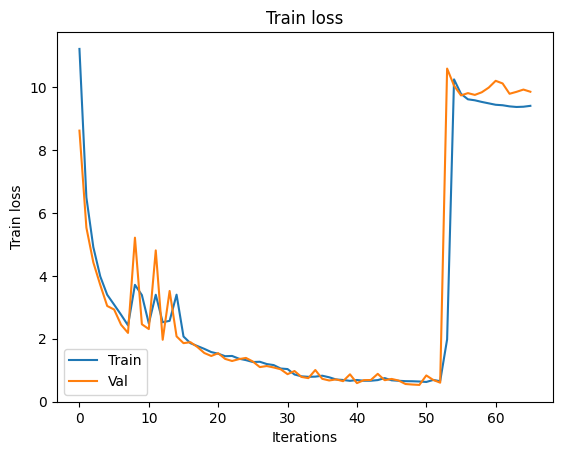

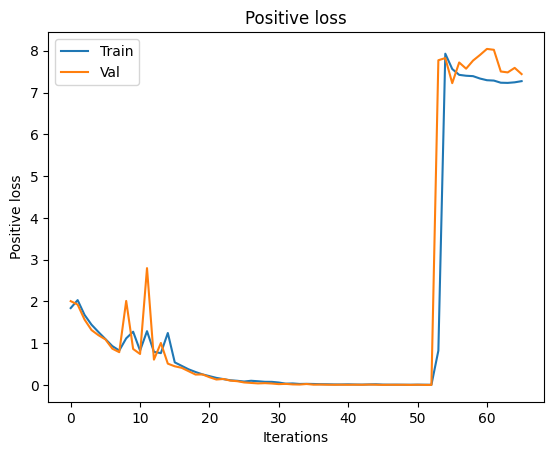

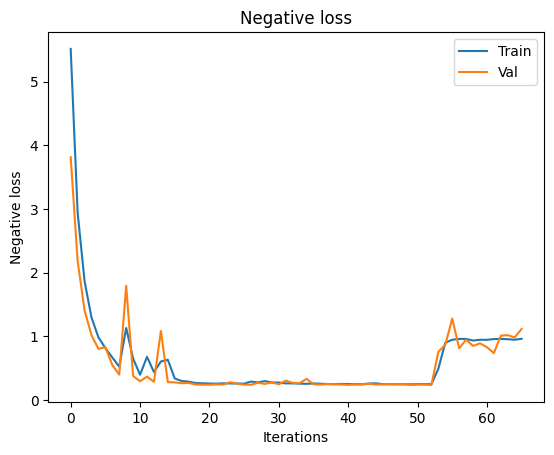

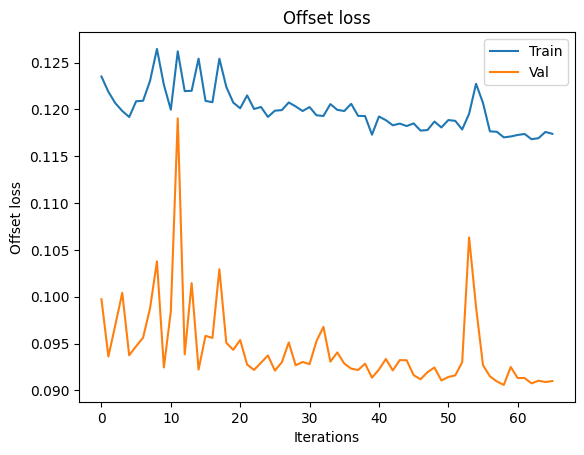

In [41]:
loss_iter = [log["train_loss"] for log in logs]
val_loss_iter = [log["val_loss"] for log in logs]
plt.plot(loss_iter[1:], label="Train")
plt.plot(val_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Train loss")
plt.title("Train loss")
plt.legend()
plt.show()

pos_loss_iter = [log["train_pos_loss"] for log in logs]
val_pos_loss_iter = [log["val_pos_loss"] for log in logs]
plt.plot(pos_loss_iter[1:], label="Train")
plt.plot(val_pos_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Positive loss")
plt.title("Positive loss")
plt.legend()
plt.show()

neg_loss_iter = [log["train_neg_loss"] for log in logs]
val_neg_loss_iter = [log["val_neg_loss"] for log in logs]
plt.plot(neg_loss_iter[1:], label="Train")
plt.plot(val_neg_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Negative loss")
plt.title("Negative loss")
plt.legend()
plt.show()

off_loss_iter = [log["train_off_loss"] for log in logs]
val_off_loss_iter = [log["val_off_loss"] for log in logs]
plt.plot(off_loss_iter[1:], label="Train")
plt.plot(val_off_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Offset loss")
plt.title("Offset loss")
plt.legend()
plt.show()

In [42]:
classes

['cup']

In [43]:
best_loss

0.5312990026120602

# Show predictions

In [44]:
model.load_state_dict(torch.load(f"centernet-xml-seg-{name}.pth"))
model.eval()

centernet(
  (base_model): FeatureListNet(
    (stem_0): Conv2d(3, 40, kernel_size=(4, 4), stride=(4, 4))
    (stem_1): LayerNorm2d((40,), eps=1e-06, elementwise_affine=True)
    (stages_0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(40, 40, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=40)
          (norm): LayerNorm2d((40,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Conv2d(40, 160, kernel_size=(1, 1), stride=(1, 1))
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Conv2d(160, 40, kernel_size=(1, 1), stride=(1, 1))
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(40, 40, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=40)


traced_model = torch.jit.trace(model, [img[None].cuda()])

torch.jit.save(traced_model, f"traced_centernet-barcode-{name}.pt")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


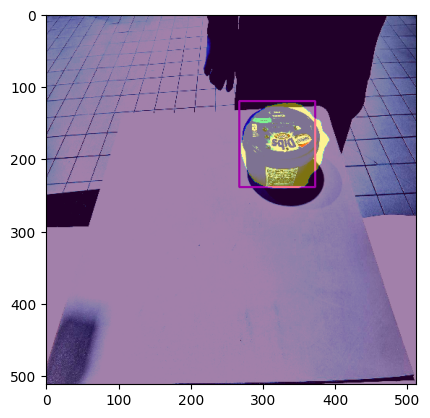

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


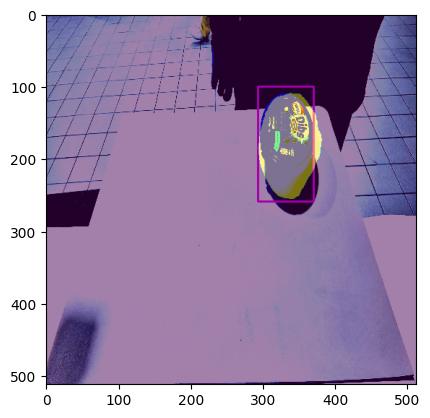

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


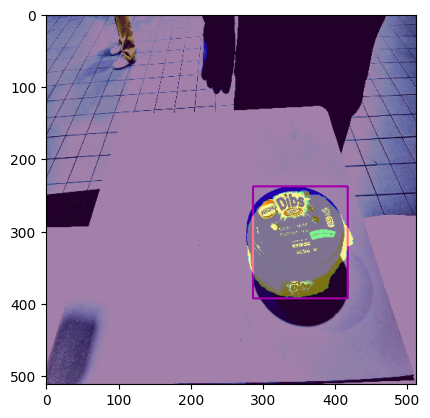

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


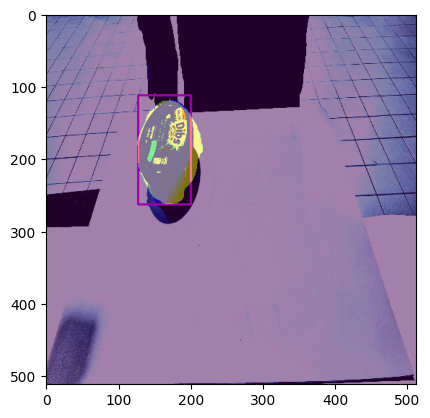

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


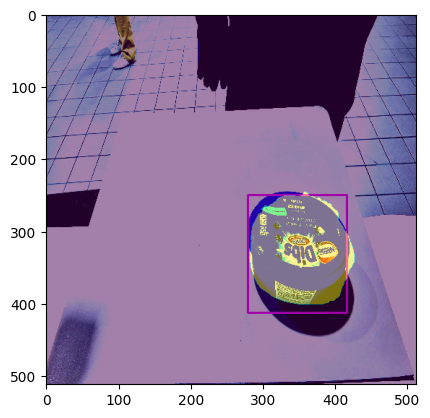

(512, 512, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


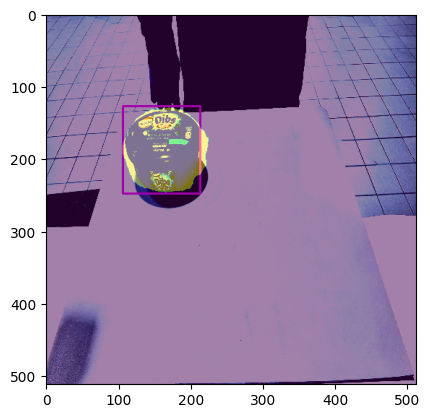

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


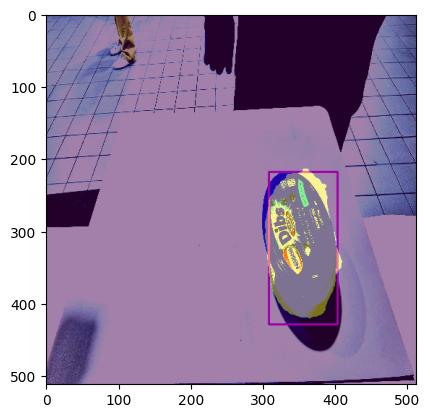

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


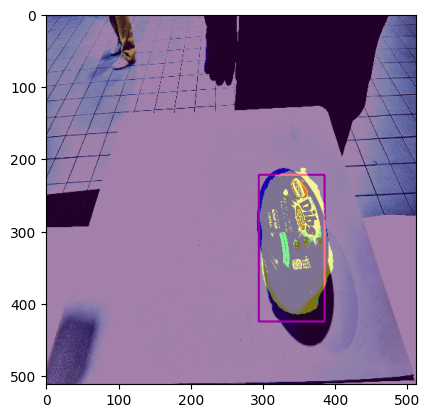

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


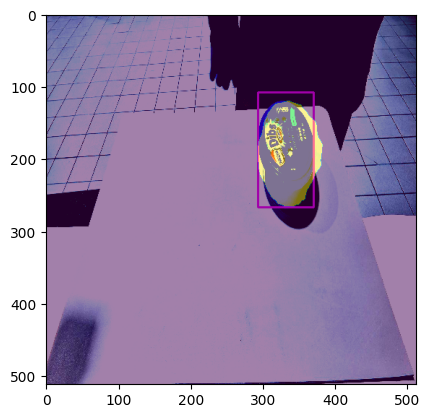

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


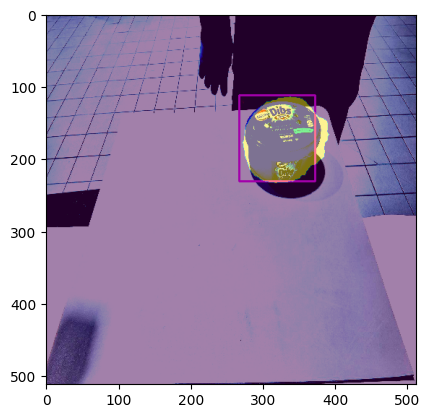

In [49]:
for id in range(10):
    img, hm_gt, offset_gt, regr_gt,hm_all,mask = valdataset[id]
    sample = np.transpose(img,(1,2,0)).copy()
    print(sample.shape)
    image_shape = np.array(np.shape(img)[0:2])
    img = torch.from_numpy(img)
    with torch.no_grad():
        hm, offset, wh,predmask = model(img.to(device).float().unsqueeze(0))
    offset = offset.cpu().numpy().squeeze(0)
    wh = wh.cpu().numpy().squeeze(0)
    hm = torch.sigmoid(hm)
    outputs = decode_bbox(hm,torch.tensor(wh[None]).cuda(),torch.tensor(offset[None]).cuda())
    results = postprocess(outputs,True,[512, 512],image_shape, False, 0.3)
    try:
        top_label   = np.array(results[0][:, 5], dtype = 'int32')
        top_conf    = results[0][:, 4]
        top_boxes   = results[0][:, :4]
        for box in top_boxes:
            ymin = box[0]
            xmin = box[1] 
            ymax = box[2] 
            xmax = box[3] 

            xmin = int(xmin)
            ymin = int(ymin)
            xmax = int(xmax)
            ymax = int(ymax)

            cv2.rectangle(sample,(xmin,ymin),(xmax,ymax),(255,0,255),2)
    except:
        pass

    mask_output = torch.sigmoid(predmask)[0][0].cpu().numpy() 
    mask_output = cv2.resize(mask_output,(512,512))
    plt.imshow(sample)
    plt.imshow(mask_output > 0.3 ,alpha=0.5)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
[[128.47407407 271.2        242.25185185 379.2       ]]


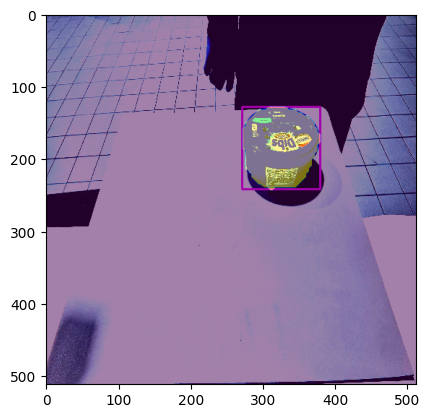

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
[[110.93333333 296.26666667 253.62962963 371.2       ]]


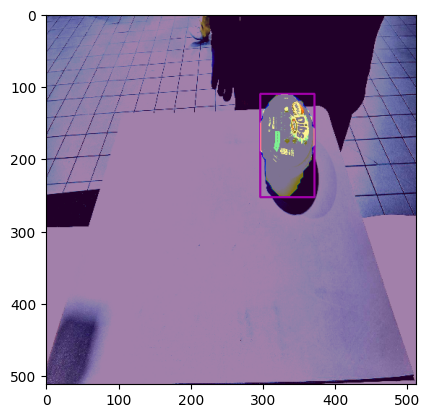

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
[[238.93333333 277.33333333 390.63703704 413.33333333]]


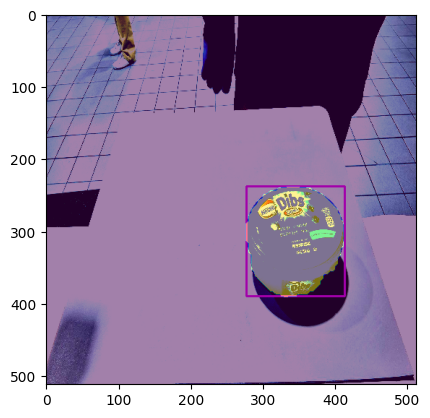

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
[[119.46666667 128.26666667 265.48148148 204.26666667]]


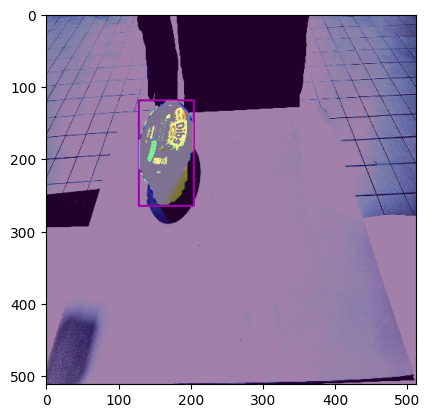

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
[[246.04444444 279.2        402.96296296 420.26666667]]


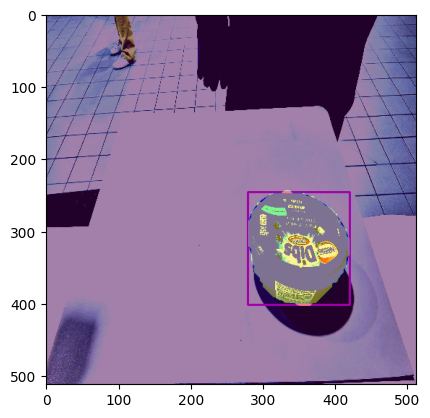

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
[[133.68888889 110.4        246.04444444 215.2       ]]


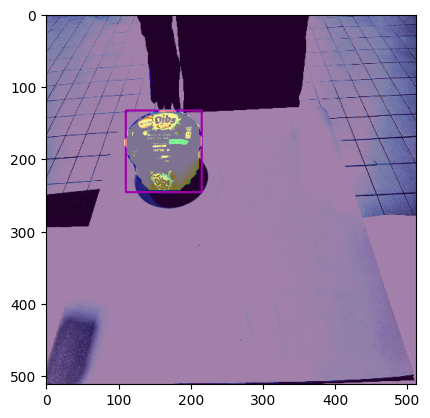

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
[[217.6        299.2        423.82222222 402.4       ]]


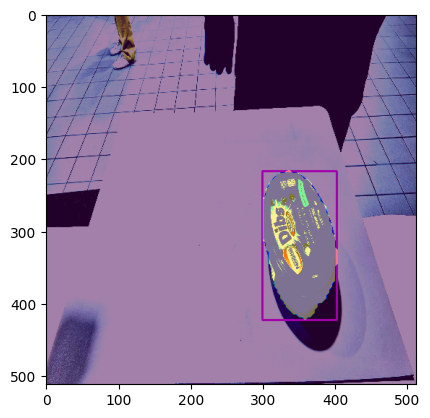

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
[[213.80740741 292.26666667 416.71111111 391.2       ]]


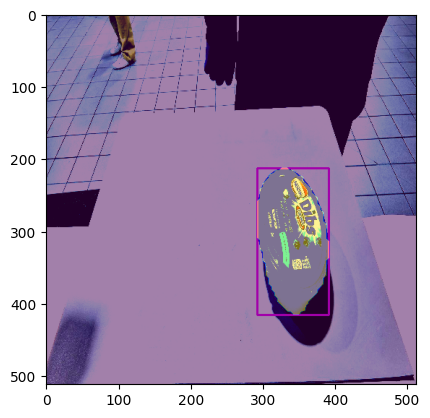

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
[[121.36296296 294.4        271.64444444 372.26666667]]


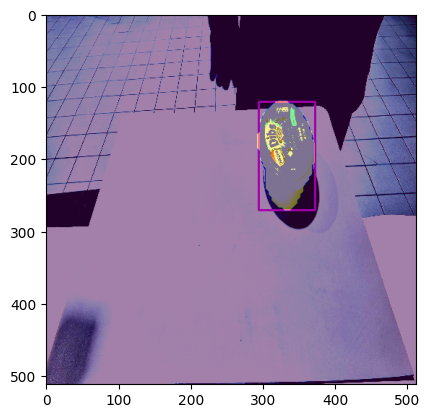

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
[[121.36296296 276.26666667 233.24444444 380.26666667]]


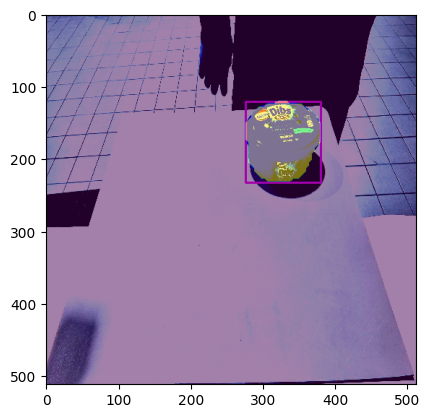

In [48]:
"""
Ground Truth of Validation

"""

for id in range(10):
    img, hm_gt, offset_gt, regr_gt,hm_all,mask = valdataset[id]
    sample = np.transpose(img,(1,2,0)).copy()
    print(sample.shape)
    image_shape = np.array(np.shape(img)[0:2])
    img = torch.from_numpy(img)
    with torch.no_grad():
        hm, offset, wh , corner = model(img.to(device).float().unsqueeze(0))
    offset = offset.cpu().numpy().squeeze(0)
    wh = wh.cpu().numpy().squeeze(0)
    hm = torch.tensor(hm_gt)
    outputs = decode_bbox(hm[None].cuda(),torch.tensor(regr_gt[None]).cuda(),torch.tensor(offset_gt[None]).cuda())
    results = postprocess(outputs,True,[512, 512],image_shape, False, 0.3)
    top_label   = np.array(results[0][:, 5], dtype = 'int32')
    top_conf    = results[0][:, 4]
    top_boxes   = results[0][:, :4]
    print(top_boxes)
    for box in top_boxes:
        ymin = box[0]
        xmin = box[1] 
        ymax = box[2] 
        xmax = box[3] 

        xmin = int(xmin)
        ymin = int(ymin)
        xmax = int(xmax)
        ymax = int(ymax)

        cv2.rectangle(sample,(xmin,ymin),(xmax,ymax),(255,0,255),2)
    #mask_output = torch.sigmoid(predmask)[0][0].cpu().numpy() 
    mask_output = cv2.resize(mask,(512,512))
    plt.imshow(sample)
    plt.imshow(mask_output > 0.6 ,alpha=0.5)
    plt.show()